In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"CUDA доступна. Используется GPU: {physical_devices[0]}")
else:
    print("CUDA недоступна. Используется CPU")

CUDA недоступна. Используется CPU


# Двухбашенная нейросеть для рекомендательных систем

## Архитектура двухбашенной модели

Двухбашенная нейросеть состоит из двух основных компонентов, которые обучаются совместно:

- **User Tower** - преобразует признаки пользователя в векторное представление (эмбеддинг)
- **Item Tower** - преобразует признаки объекта/контента в векторное представление

### Математическая формализация

Пусть:
- $\mathbf{x}_u \in \mathbb{R}^{d_u}$ - вектор признаков пользователя
- $\mathbf{x}_i \in \mathbb{R}^{d_i}$ - вектор признаков объекта
- $\Theta_U$ - параметры пользовательской башни
- $\Theta_I$ - параметры объектной башни

Тогда:
$$
\mathbf{u} = f_U(\mathbf{x}_u; \Theta_U) \quad \text{— эмбеддинг пользователя}
$$
$$
\mathbf{v} = f_I(\mathbf{x}_i; \Theta_I) \quad \text{— эмбеддинг объекта}
$$

Скоринговая функция (вероятность взаимодействия):
$$
\hat{y}_{ui} = \sigma(\mathbf{u}^T \mathbf{v}) = \frac{1}{1 + \exp(-\mathbf{u}^T \mathbf{v})}
$$

где $\sigma(\cdot)$ - сигмоидная функция.
------

## Детальное описание башен

### Пользовательская башня (User Tower)

Многослойный перцептрон с $L$ слоями:

$$
\begin{aligned}
\mathbf{h}_u^{(1)} &= \text{ReLU}(W_U^{(1)} \mathbf{x}_u + \mathbf{b}_U^{(1)}) \\
\mathbf{h}_u^{(2)} &= \text{ReLU}(W_U^{(2)} \mathbf{h}_u^{(1)} + \mathbf{b}_U^{(2)}) \\
&\vdots \\
\mathbf{h}_u^{(L)} &= \text{ReLU}(W_U^{(L)} \mathbf{h}_u^{(L-1)} + \mathbf{b}_U^{(L)}) \\
\mathbf{u} &= \mathbf{h}_u^{(L)}
\end{aligned}
$$

**Компоненты:**
- $W_U^{(l)} \in \mathbb{R}^{h_l \times h_{l-1}}$ - матрица весов слоя $l$
- $\mathbf{b}_U^{(l)} \in \mathbb{R}^{h_l}$ - вектор смещений слоя $l$
- $h_0 = d_u$ - размерность входных признаков
- $h_L = d$ - размерность выходного эмбеддинга
- $\text{ReLU}(z) = \max(0, z)$ - функция активации

### Башня объектов (Item Tower)

Аналогичная архитектура:
$$
\begin{aligned}
\mathbf{h}_i^{(1)} &= \text{ReLU}(W_I^{(1)} \mathbf{x}_i + \mathbf{b}_I^{(1)}) \\
&\vdots \\
\mathbf{v} &= \mathbf{h}_i^{(L)}
\end{aligned}
$$

----------------------

## Функции потерь

### 1. Binary Cross-Entropy Loss

**Формула:**
$$
\mathcal{L}_{BCE} = -\frac{1}{N} \sum_{n=1}^N \left[ y_n \log(\hat{y}_n) + (1 - y_n) \log(1 - \hat{y}_n) \right]
$$

**Компоненты:**
- $N$ - количество примеров в батче
- $y_n \in \{0,1\}$ - бинарная метка взаимодействия (1 - было взаимодействие, 0 - не было)
- $\hat{y}_n \in [0,1]$ - предсказанная вероятность взаимодействия
- $\log$ - натуральный логарифм

**Применение:** Когда у нас есть явные положительные и отрицательные примеры.

---

### 2. BPR Loss (Bayesian Personalized Ranking)

**Формула:**
$$
\mathcal{L}_{BPR} = -\frac{1}{|\mathcal{D}|} \sum_{(u,i,j) \in \mathcal{D}} \log \sigma(\mathbf{u}^T \mathbf{v}_i - \mathbf{u}^T \mathbf{v}_j)
$$

**Компоненты:**
- $\mathcal{D} = \{(u,i,j)\}$ - множество триплетов (пользователь, позитивный объект, негативный объект)
- $\mathbf{u}^T \mathbf{v}_i$ - оценка для позитивного объекта
- $\mathbf{u}^T \mathbf{v}_j$ - оценка для негативного объекта
- $\sigma(x) = \frac{1}{1 + e^{-x}}$ - сигмоидная функция
- $|\mathcal{D}|$ - количество триплетов в батче

**Интуиция:** Максимизирует разницу между оценками позитивных и негативных объектов.

---

### 3. Triplet Loss

**Формула:**
$$
\mathcal{L}_{Triplet} = \frac{1}{|\mathcal{D}|} \sum_{(u,i,j) \in \mathcal{D}} \max(0, \|\mathbf{u} - \mathbf{v}_i\|^2 - \|\mathbf{u} - \mathbf{v}_j\|^2 + \alpha)
$$

**Компоненты:**
- $\|\mathbf{u} - \mathbf{v}_i\|^2$ - квадрат евклидова расстояния до позитивного объекта
- $\|\mathbf{u} - \mathbf{v}_j\|^2$ - квадрат евклидова расстояния до негативного объекта
- $\alpha > 0$ - параметр margin (зазор)
- $\max(0, \cdot)$ - функция хиндж-потерь

**Интуиция:** Позитивные объекты должны быть ближе к пользователю, чем негативные, с запасом не менее $\alpha$.


--------------

## Процесс обучения

### Прямое распространение (Forward Pass)

Для одного примера $(u,i)$:
$$
\begin{aligned}
\mathbf{u} &= f_U(\mathbf{x}_u; \Theta_U) \\
\mathbf{v} &= f_I(\mathbf{x}_i; \Theta_I) \\
s &= \mathbf{u}^T \mathbf{v} \\
\hat{y} &= \sigma(s) \\
\mathcal{L} &= \text{loss}(\hat{y}, y)
\end{aligned}
$$

### Обратное распространение (Backward Pass)

Градиенты для обновления параметров:
$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \Theta_U} &= \frac{\partial \mathcal{L}}{\partial \mathbf{u}} \cdot \frac{\partial \mathbf{u}}{\partial \Theta_U} \\
\frac{\partial \mathcal{L}}{\partial \Theta_I} &= \frac{\partial \mathcal{L}}{\partial \mathbf{v}} \cdot \frac{\partial \mathbf{v}}{\partial \Theta_I}
\end{aligned}
$$

где:
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{u}} = \frac{\partial \mathcal{L}}{\partial s} \cdot \mathbf{v}, \quad \frac{\partial \mathcal{L}}{\partial \mathbf{v}} = \frac{\partial \mathcal{L}}{\partial s} \cdot \mathbf{u}
$$

## Регуляризация

### L2 Регуляризация (Weight Decay)
$$
\mathcal{L}_{total} = \mathcal{L}_{data} + \frac{\lambda}{2} \left( \|\Theta_U\|_2^2 + \|\Theta_I\|_2^2 \right)
$$

где $\lambda$ - коэффициент регуляризации.

### Dropout
Во время обучения:
$$
\mathbf{h}_{out} = \mathbf{m} \odot \text{ReLU}(W \mathbf{h}_{in} + \mathbf{b})
$$
где $\mathbf{m} \sim \text{Bernoulli}(p)$ - бинарная маска.

---------------

## Практические рекомендации

### Выбор функции потерь:
- **Binary Cross-Entropy** - для явных взаимодействий с негативными примерами
- **BPR** - для неявного фидбека и задач ранжирования  
- **Triplet Loss** - когда важны относительные расстояния в эмбеддинг-пространстве


### Размерность эмбеддингов:
- Обычно $d = 64-512$ в зависимости от сложности данных
- Большая размерность лучше "ловит" сложные паттерны, но требует больше данных

### Стратегия негативного сэмплирования:
- Случайные негативы из непросмотренных объектов
- Популярные негативы (часто просматриваемые другими)
- Hard negatives (похожие на позитивные, но не просмотренные)

# REKKO CHALLENGE - Нейросетевая рекомендательная система

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Dot, BatchNormalization, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [ ]:
transactions = pd.read_csv('transactions.csv')
ratings = pd.read_csv('ratings.csv')
bookmarks = pd.read_csv('bookmarks.csv')

with open('catalogue.json', 'r') as f:
    catalogue = json.load(f)

with open('test_users.json', 'r') as f:
    test_users = json.load(f)
display(transactions.head())
print('\n')
display(ratings.head())
print('\n')
display(bookmarks.head())

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50
3,6272,74296,S,4.430518e+07,2530,0,99
4,5543,340623,P,4.430518e+07,6282,0,50


,user_uid,element_uid,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07
3,359870,1364,10,4.430506e+07
4,359870,3578,9,4.430506e+07


,user_uid,element_uid,ts
0,301135,7185,4.430516e+07
1,301135,4083,4.430516e+07
2,301135,10158,4.430516e+07
3,301135,2693,4.430516e+07
4,301135,2181,4.430515e+07


https://boosters.pro/championship/rekko_challenge/data

https://www.kaggle.com/datasets/g0ohard/rekko-challenge

https://habr.com/ru/companies/okko/articles/439180/

transactions.csv  — информация о транзакциях (покупках и просмотрах по подписке) со временем просмотра по каждой транзакции
Описание фичей в transactions.csv:
1. user_uid — уникальный идентификатор пользователя
2.  element_uid — уникальный идентификатор контента
3.  consumption_mode — тип потребления (переменная принимает следующие значения: P — покупка, R — аренда, S — просмотр по подписке)
4.  ts — время совершения операции
5.  watched_time — время просмотра в секундах
6. device_type — тип устройства, с которого была совершена покупка или начат просмотр по подписке
7. device_manufacturer — фирма-изготовитель устройства, с которого была совершена покупка или начат просмотр по подписке

ratings.csv  — информация об оценках, поставленных пользователями
Описание фичей в ratings.csv:
1. user_uid — уникальный идентификатор пользователя
2. element_uid — уникальный идентификатор контента
3. ts — время постановки рейтинга
4. rating — поставленный пользователем рейтинг

bookmarks.csv   — информация о фильмах, добавленных пользователями в «Запомненное»
Описание фичей в bookmarks.csv:
1. user_uid — уникальный идентификатор пользователя
2. element_uid — уникальный идентификатор контента
3. ts — время добавления контента в «Запомненное»

catalogue.json  — метаинформация о контенте
Описание фичей в catalogue.json:
1. type — тип элемента
2. duration — длительность в минутах (средняя длительность эпизода в случае с сериалами и многосерийными фильмами), округлённая до десятков
3. attributes — анонимизированные атрибуты данного элемента
4. availability — доступные права на элемент(subscription, purchase, rent)
5. feature_1 — анонимизированная вещественная переменная
6. feature_2 — анонимизированная вещественная переменная
7. feature_3 — анонимизированная порядковая переменная
8. feature_4 — анонимизированная вещественная переменная
9. feature_5 — анонимизированная вещественная переменная

test_users.json — пользователи, для которых необходимо построить предсказание
sample_answer.json — пример решения

### Детальный анализ transactions данных

In [ ]:
def analyze_transactions(transactions):

    print("1. ОСНОВНАЯ ИНФОРМАЦИЯ:")
    print(f"   Всего записей: {len(transactions):,}")
    print(f"   Период данных: {transactions['ts'].min()} - {transactions['ts'].max()}")
    print(f"   Длительность периода: {transactions['ts'].max() - transactions['ts'].min():,} единиц")
    print(f"   Уникальных пользователей: {transactions['user_uid'].nunique():,}")
    print(f"   Уникальных фильмов: {transactions['element_uid'].nunique():,}")

    print(f"\n2. ТИПЫ ПОТРЕБЛЕНИЯ:")
    consumption_stats = transactions['consumption_mode'].value_counts()
    for mode, count in consumption_stats.items():
        percentage = (count / len(transactions)) * 100
        print(f"   {mode}: {count:,} ({percentage:.1f}%)")

    print(f"\n3. УСТРОЙСТВА:")
    print(f"   Типов устройств: {transactions['device_type'].nunique()}")
    print(f"   Производителей: {transactions['device_manufacturer'].nunique()}")


    top_devices = transactions['device_type'].value_counts().head(5)
    print("   Топ-5 типов устройств:")
    for device, count in top_devices.items():
        print(f"     {device}: {count:,}")


    print(f"\n4. ВРЕМЯ ПРОСМОТРА:")
    print(f"   Среднее время: {transactions['watched_time'].mean():.1f} сек")
    print(f"   Медиана: {transactions['watched_time'].median():.1f} сек")
    print(f"   Максимум: {transactions['watched_time'].max():,} сек")
    print(f"   Минимум: {transactions['watched_time'].min()} сек")

    print(f"\n5. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
    missing_data = transactions.isnull().sum()
    print(f'Пропущенных значение - \n{missing_data}')

    return transactions

print("Анализируем transactions данные...")
transactions = analyze_transactions(transactions)

Анализируем transactions данные...
1. ОСНОВНАЯ ИНФОРМАЦИЯ:
   Всего записей: 9,643,012
   Период данных: 41730633.135421805 - 44305181.2180206
   Длительность периода: 2,574,548.082598798 единиц
   Уникальных пользователей: 499,663
   Уникальных фильмов: 8,296

2. ТИПЫ ПОТРЕБЛЕНИЯ:
   S: 8,296,227 (86.0%)
   P: 873,834 (9.1%)
   R: 472,951 (4.9%)

3. УСТРОЙСТВА:
   Типов устройств: 7
   Производителей: 100
   Топ-5 типов устройств:
     0: 7,651,772
     3: 855,860
     5: 591,265
     1: 298,108
     4: 219,254

4. ВРЕМЯ ПРОСМОТРА:
   Среднее время: 6338.2 сек
   Медиана: 4959.0 сек
   Максимум: 4,326,296 сек
   Минимум: 0 сек

5. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
Пропущенных значение - 
element_uid            0
user_uid               0
consumption_mode       0
ts                     0
watched_time           0
device_type            0
device_manufacturer    0
dtype: int64


In [ ]:
total_interactions = len(transactions)
unique_users = transactions['user_uid'].nunique()
unique_movies = transactions['element_uid'].nunique()

potential_interactions = unique_users * unique_movies  # ~4.14 миллиарда
actual_interactions = total_interactions
sparsity = (1 - (actual_interactions / potential_interactions)) * 100

print(f"Потенциальных взаимодействий: {potential_interactions:.6f}")
print(f"Разреженность: {sparsity:.6f}%")


Потенциальных взаимодействий: 4145204248.000000
Разреженность: 99.767369%


### Анализ временных паттернов

- Время выражено в абстрактных единицах, для которых сохранено расстояние и отношение порядка. Анализируем относительное время:

Анализ абстрактных временных меток
Диапазон временных меток: 41730633.14 - 44305181.22
Общий диапазон: 2574548.08 единиц

Нормализованный диапазон: 0 - 1


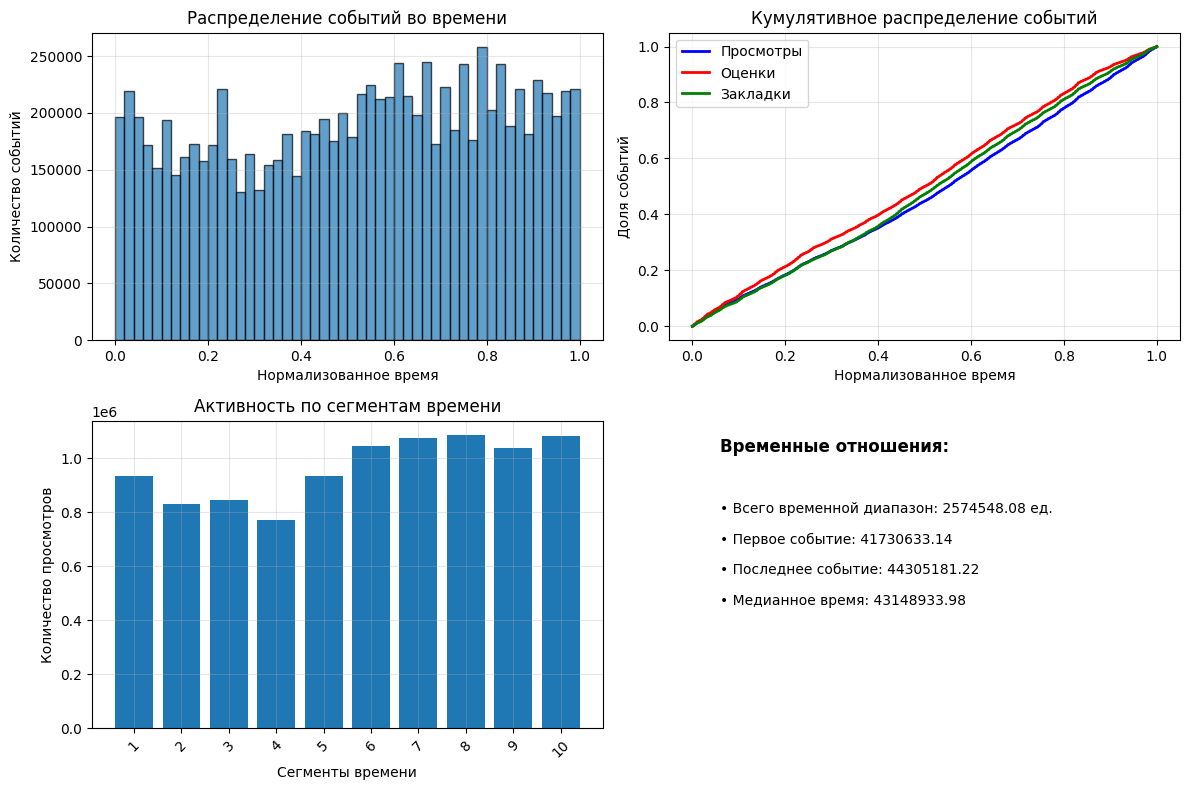


Временные паттерны пользователей:
Средняя длительность активности пользователя: 972058.50 ед.
Максимальная длительность: 2574353.09 ед.
Пользователей с одним днем активности: 333


In [ ]:
print("Анализ абстрактных временных меток")

print(f"Диапазон временных меток: {transactions['ts'].min():.2f} - {transactions['ts'].max():.2f}")
print(f"Общий диапазон: {transactions['ts'].max() - transactions['ts'].min():.2f} единиц")

# нормализуем временные метки
ts_min = transactions['ts'].min()
ts_range = transactions['ts'].max() - ts_min

transactions['ts_norm'] = (transactions['ts'] - ts_min) / ts_range
ratings['ts_norm'] = (ratings['ts'] - ts_min) / ts_range
bookmarks['ts_norm'] = (bookmarks['ts'] - ts_min) / ts_range

print(f"\nНормализованный диапазон: 0 - 1")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# распределение временных меток
ax1.hist(transactions['ts_norm'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Нормализованное время')
ax1.set_ylabel('Количество событий')
ax1.set_title('Распределение событий во времени')
ax1.grid(True, alpha=0.3)

# кумулятивное распределение
cumulative_data = []
for name, df, color in [('Просмотры', transactions, 'blue'),
                        ('Оценки', ratings, 'red'),
                        ('Закладки', bookmarks, 'green')]:
    sorted_ts = np.sort(df['ts_norm'])
    cumulative = np.arange(len(sorted_ts)) / float(len(sorted_ts))
    ax2.plot(sorted_ts, cumulative, label=name, color=color, linewidth=2)

ax2.set_xlabel('Нормализованное время')
ax2.set_ylabel('Доля событий')
ax2.set_title('Кумулятивное распределение событий')
ax2.legend()
ax2.grid(True, alpha=0.3)

# активность по сегментам времени
time_segments = pd.cut(transactions['ts_norm'], bins=10)
segment_activity = transactions.groupby(time_segments).size()

ax3.bar(range(len(segment_activity)), segment_activity.values)
ax3.set_xlabel('Сегменты времени')
ax3.set_ylabel('Количество просмотров')
ax3.set_title('Активность по сегментам времени')
ax3.set_xticks(range(len(segment_activity)))
ax3.set_xticklabels([f'{i}' for i in range(1, 11)], rotation=45)
ax3.grid(True, alpha=0.3)

# временные задержки между типами событий
ax4.axis('off')
ax4.text(0.1, 0.9, "Временные отношения:", fontsize=12, fontweight='bold')
ax4.text(0.1, 0.7, f"• Всего временной диапазон: {ts_range:.2f} ед.", fontsize=10)
ax4.text(0.1, 0.6, f"• Первое событие: {ts_min:.2f}", fontsize=10)
ax4.text(0.1, 0.5, f"• Последнее событие: {transactions['ts'].max():.2f}", fontsize=10)
ax4.text(0.1, 0.4, f"• Медианное время: {transactions['ts'].median():.2f}", fontsize=10)

plt.tight_layout()
plt.show()

print("\nВременные паттерны пользователей:")
user_first_last = transactions.groupby('user_uid')['ts'].agg(['min', 'max'])
user_first_last['duration'] = user_first_last['max'] - user_first_last['min']
print(f"Средняя длительность активности пользователя: {user_first_last['duration'].mean():.2f} ед.")
print(f"Максимальная длительность: {user_first_last['duration'].max():.2f} ед.")
print(f"Пользователей с одним днем активности: {(user_first_last['duration'] == 0).sum()}")

### Анализ пересечения пользователей

Пересечение пользователей между датасетами
Всего уникальных пользователей: 500000

Попарные пересечения:
Просмотры & Оценки: 104226 пользователей (20.8%)
Просмотры & Закладки: 146982 пользователей (29.4%)
Оценки & Закладки: 47555 пользователей (9.5%)
Все три датасета: 47370 пользователей (9.5%)

Уникальные пользователи:
Только просмотры: 295825 (59.2%)
Только оценки: 152 (0.0%)
Только закладки: 0 (0.0%)


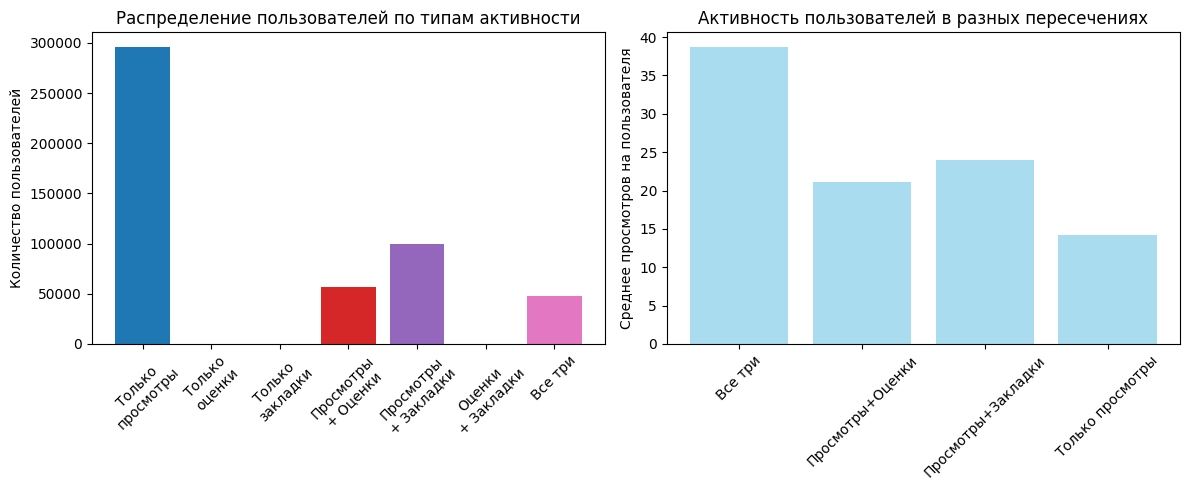


Активность пользователей в пересечениях:
Все три: 38.7 просмотров на пользователя
Просмотры+Оценки: 21.2 просмотров на пользователя
Просмотры+Закладки: 24.0 просмотров на пользователя
Только просмотры: 14.3 просмотров на пользователя
Только оценки: nan просмотров на пользователя


In [ ]:

users_trans = set(transactions['user_uid'])
users_ratings = set(ratings['user_uid'])
users_bookmarks = set(bookmarks['user_uid'])

print("Пересечение пользователей между датасетами")
total_users = len(users_trans | users_ratings | users_bookmarks)
print(f"Всего уникальных пользователей: {total_users}")

# попарные пересечения
trans_ratings = users_trans & users_ratings
trans_bookmarks = users_trans & users_bookmarks
ratings_bookmarks = users_ratings & users_bookmarks

print(f"\nПопарные пересечения:")
print(f"Просмотры & Оценки: {len(trans_ratings)} пользователей ({len(trans_ratings)/total_users:.1%})")
print(f"Просмотры & Закладки: {len(trans_bookmarks)} пользователей ({len(trans_bookmarks)/total_users:.1%})")
print(f"Оценки & Закладки: {len(ratings_bookmarks)} пользователей ({len(ratings_bookmarks)/total_users:.1%})")

# тройное пересечение
all_three = users_trans & users_ratings & users_bookmarks
print(f"Все три датасета: {len(all_three)} пользователей ({len(all_three)/total_users:.1%})")

# уникальные пользователи
only_trans = users_trans - users_ratings - users_bookmarks
only_ratings = users_ratings - users_trans - users_bookmarks
only_bookmarks = users_bookmarks - users_trans - users_ratings

print(f"\nУникальные пользователи:")
print(f"Только просмотры: {len(only_trans)} ({len(only_trans)/total_users:.1%})")
print(f"Только оценки: {len(only_ratings)} ({len(only_ratings)/total_users:.1%})")
print(f"Только закладки: {len(only_bookmarks)} ({len(only_bookmarks)/total_users:.1%})")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

venn_data = {
    'transactions': len(only_trans),
    'ratings': len(only_ratings),
    'bookmarks': len(only_bookmarks),
    'trans_ratings': len(trans_ratings - all_three),
    'trans_bookmarks': len(trans_bookmarks - all_three),
    'ratings_bookmarks': len(ratings_bookmarks - all_three),
    'all_three': len(all_three)
}

labels = ['Только\nпросмотры', 'Только\nоценки', 'Только\nзакладки',
          'Просмотры\n+ Оценки', 'Просмотры\n+ Закладки', 'Оценки\n+ Закладки', 'Все три']
values = [venn_data['transactions'], venn_data['ratings'], venn_data['bookmarks'],
          venn_data['trans_ratings'], venn_data['trans_bookmarks'],
          venn_data['ratings_bookmarks'], venn_data['all_three']]

ax1.bar(labels, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])
ax1.set_ylabel('Количество пользователей')
ax1.set_title('Распределение пользователей по типам активности')
ax1.tick_params(axis='x', rotation=45)

# активность пользователей в пересечениях
intersection_activity = []
intersection_labels = []

for users, label in [
    (all_three, 'Все три'),
    (trans_ratings - all_three, 'Просмотры+Оценки'),
    (trans_bookmarks - all_three, 'Просмотры+Закладки'),
    (only_trans, 'Только просмотры'),
    (only_ratings, 'Только оценки'),
    (only_bookmarks, 'Только закладки')
]:
    if users:
        user_activity = transactions[transactions['user_uid'].isin(users)].groupby('user_uid').size().mean()
        intersection_activity.append(user_activity)
        intersection_labels.append(label)

ax2.bar(intersection_labels, intersection_activity, color='skyblue', alpha=0.7)
ax2.set_ylabel('Среднее просмотров на пользователя')
ax2.set_title('Активность пользователей в разных пересечениях')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nАктивность пользователей в пересечениях:")
for label, activity in zip(intersection_labels, intersection_activity):
    print(f"{label}: {activity:.1f} просмотров на пользователя")

### Визуализация распределений

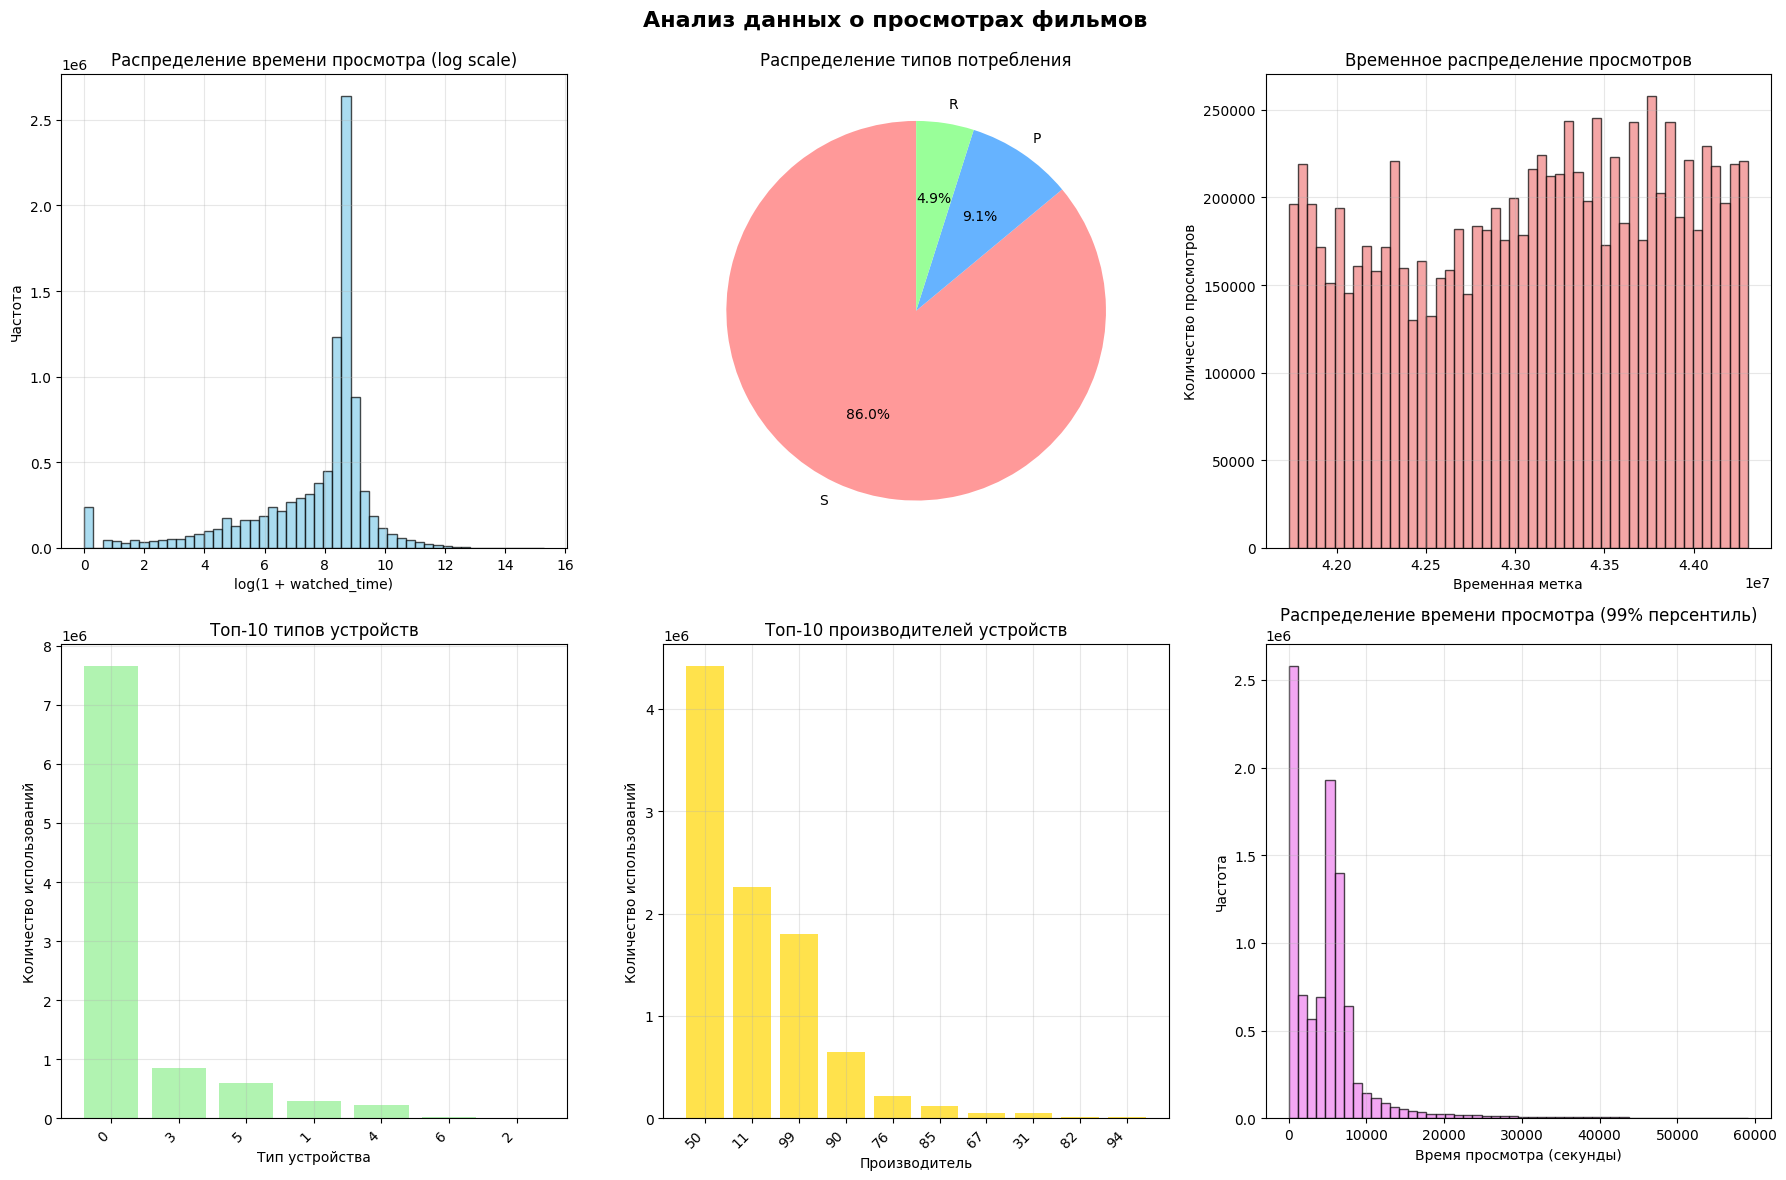

ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:
   Просмотры > 1 часа: 5,772,314
   Просмотры < 5 минут: 1,562,534
   95% персентиль времени: 15198.0 сек
   99% персентиль времени: 59098.0 сек


In [ ]:
def create_transactions_visualizations(transactions):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Анализ данных о просмотрах фильмов', fontsize=16, fontweight='bold')

    # распределение времени просмотра (логарифмическая шкала)
    watched_time_log = np.log1p(transactions['watched_time'])
    axes[0, 0].hist(watched_time_log, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Распределение времени просмотра (log scale)')
    axes[0, 0].set_xlabel('log(1 + watched_time)')
    axes[0, 0].set_ylabel('Частота')
    axes[0, 0].grid(True, alpha=0.3)

    # типы потребления
    consumption_counts = transactions['consumption_mode'].value_counts()
    axes[0, 1].pie(consumption_counts.values, labels=consumption_counts.index,
                   autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
    axes[0, 1].set_title('Распределение типов потребления')

    # временное распределение просмотров
    time_bins = 50
    axes[0, 2].hist(transactions['ts'], bins=time_bins, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 2].set_title('Временное распределение просмотров')
    axes[0, 2].set_xlabel('Временная метка')
    axes[0, 2].set_ylabel('Количество просмотров')
    axes[0, 2].grid(True, alpha=0.3)

    # Топ-10 самых популярных устройств
    top_devices = transactions['device_type'].value_counts().head(10)
    axes[1, 0].bar(range(len(top_devices)), top_devices.values, color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('Топ-10 типов устройств')
    axes[1, 0].set_xlabel('Тип устройства')
    axes[1, 0].set_ylabel('Количество использований')
    axes[1, 0].set_xticks(range(len(top_devices)))
    axes[1, 0].set_xticklabels(top_devices.index, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)

    # распределение по производителям (топ-10)
    top_manufacturers = transactions['device_manufacturer'].value_counts().head(10)
    axes[1, 1].bar(range(len(top_manufacturers)), top_manufacturers.values, color='gold', alpha=0.7)
    axes[1, 1].set_title('Топ-10 производителей устройств')
    axes[1, 1].set_xlabel('Производитель')
    axes[1, 1].set_ylabel('Количество использований')
    axes[1, 1].set_xticks(range(len(top_manufacturers)))
    axes[1, 1].set_xticklabels(top_manufacturers.index, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)

    # анализ длительности просмотров (без выбросов)
    q99 = transactions['watched_time'].quantile(0.99)
    reasonable_watches = transactions[transactions['watched_time'] <= q99]
    axes[1, 2].hist(reasonable_watches['watched_time'], bins=50, alpha=0.7,
                   color='violet', edgecolor='black')
    axes[1, 2].set_title('Распределение времени просмотра (99% персентиль)')
    axes[1, 2].set_xlabel('Время просмотра (секунды)')
    axes[1, 2].set_ylabel('Частота')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:")
    print(f"   Просмотры > 1 часа: {len(transactions[transactions['watched_time'] > 3600]):,}")
    print(f"   Просмотры < 5 минут: {len(transactions[transactions['watched_time'] < 300]):,}")
    print(f"   95% персентиль времени: {transactions['watched_time'].quantile(0.95):.1f} сек")
    print(f"   99% персентиль времени: {transactions['watched_time'].quantile(0.99):.1f} сек")

create_transactions_visualizations(transactions)

### Анализ пользовательской активности

Анализируем поведение пользователей...
1. ОБЩАЯ СТАТИСТИКА ПОЛЬЗОВАТЕЛЕЙ:
   Всего пользователей: 499,663
   Среднее количество просмотров на пользователя: 19.3
   Медиана просмотров на пользователя: 10.0
   Среднее количество уникальных фильмов: 19.3
   Медиана уникальных фильмов: 10.0

2.  ВРЕМЯ ПРОСМОТРА:
   Среднее общее время: 34.0 часов
   Среднее время за сеанс: 97.0 минут

3. АКТИВНОСТЬ:
   Среднее количество устройств: 1.2
   Средняя длительность активности: 972058 единиц

4. РАСПРЕДЕЛЕНИЕ АКТИВНОСТИ:
   Квантили по количеству просмотров:
     25%: 5.0 просмотров
     50%: 10.0 просмотров
     75%: 22.0 просмотров
     90%: 46.0 просмотров
     95%: 69.0 просмотров
     99%: 130.0 просмотров


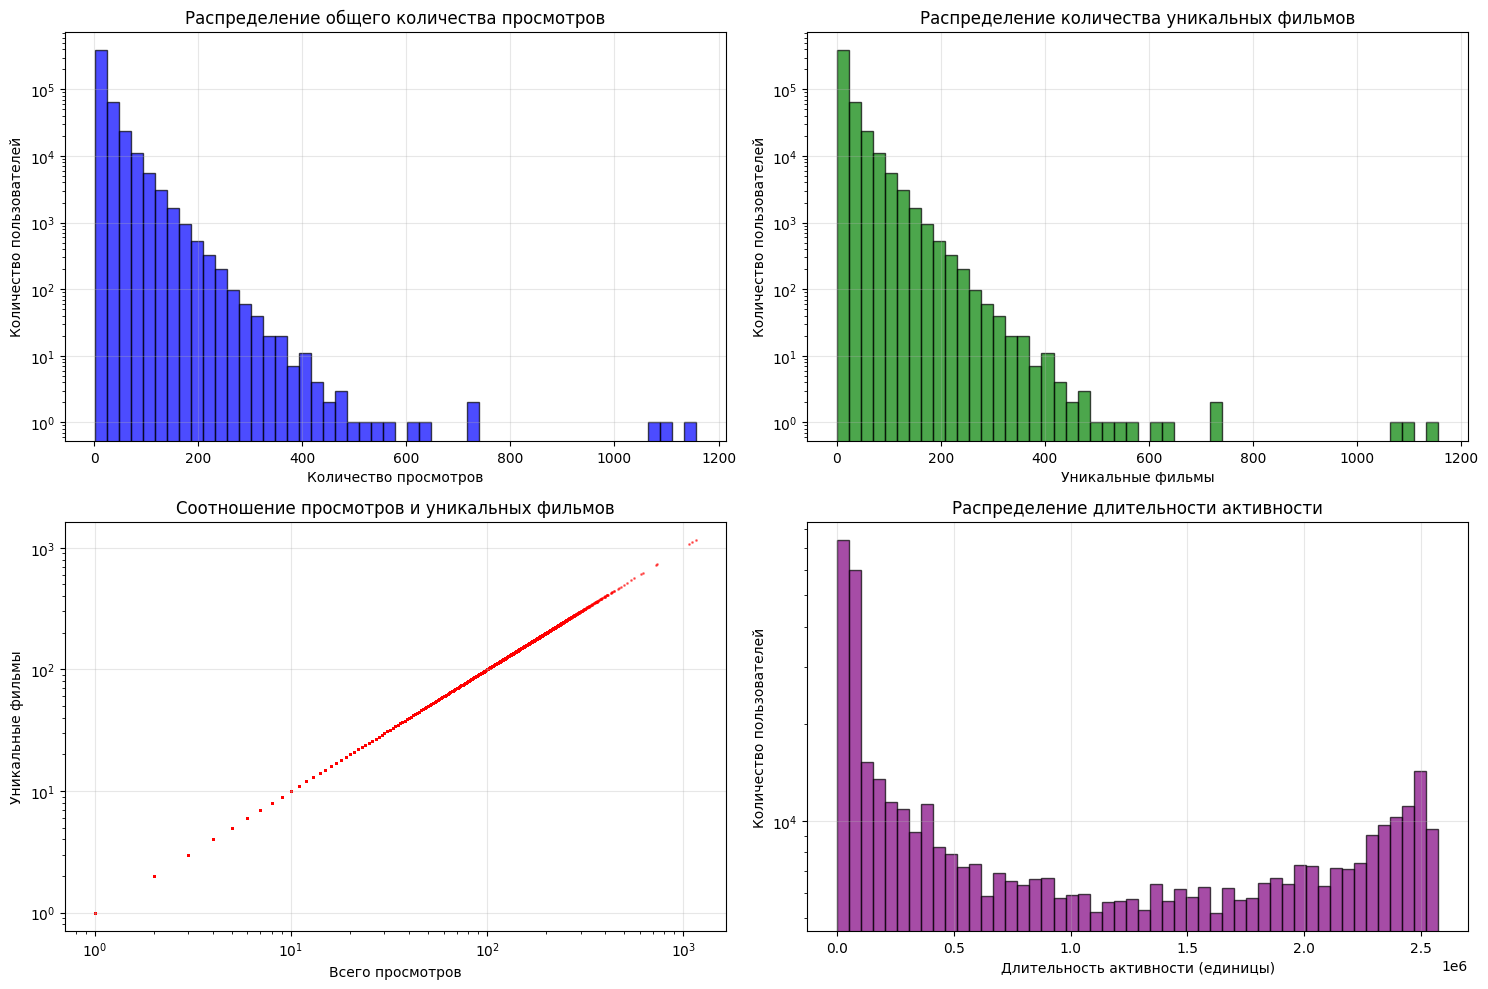

In [ ]:
def analyze_user_behavior(transactions):
    user_activity = transactions.groupby('user_uid').agg({
        'element_uid': ['count', 'nunique'],  # всего просмотров и уникальных фильмов
        'watched_time': ['sum', 'mean'],      # общее и среднее время
        'ts': ['min', 'max'],                 # первая и последняя активность
        'device_type': 'nunique',             # разнообразие устройств
        'consumption_mode': 'nunique'         # разнообразие типов потребления
    }).round(2)

    user_activity.columns = [
        'total_views', 'unique_movies', 'total_watch_time', 'avg_watch_time',
        'first_activity', 'last_activity', 'devices_count', 'consumption_types'
    ]

    user_activity['user_tenure'] = user_activity['last_activity'] - user_activity['first_activity']

    print("1. ОБЩАЯ СТАТИСТИКА ПОЛЬЗОВАТЕЛЕЙ:")
    print(f"   Всего пользователей: {len(user_activity):,}")
    print(f"   Среднее количество просмотров на пользователя: {user_activity['total_views'].mean():.1f}")
    print(f"   Медиана просмотров на пользователя: {user_activity['total_views'].median():.1f}")
    print(f"   Среднее количество уникальных фильмов: {user_activity['unique_movies'].mean():.1f}")
    print(f"   Медиана уникальных фильмов: {user_activity['unique_movies'].median():.1f}")

    print(f"\n2.  ВРЕМЯ ПРОСМОТРА:")
    print(f"   Среднее общее время: {user_activity['total_watch_time'].mean() / 3600:.1f} часов")
    print(f"   Среднее время за сеанс: {user_activity['avg_watch_time'].mean() / 60:.1f} минут")

    print(f"\n3. АКТИВНОСТЬ:")
    print(f"   Среднее количество устройств: {user_activity['devices_count'].mean():.1f}")
    print(f"   Средняя длительность активности: {user_activity['user_tenure'].mean():.0f} единиц")

    print(f"\n4. РАСПРЕДЕЛЕНИЕ АКТИВНОСТИ:")
    views_quantiles = user_activity['total_views'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
    print("   Квантили по количеству просмотров:")
    for q, value in views_quantiles.items():
        print(f"     {int(q*100)}%: {value:.1f} просмотров")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].hist(user_activity['total_views'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Распределение общего количества просмотров')
    axes[0, 0].set_xlabel('Количество просмотров')
    axes[0, 0].set_ylabel('Количество пользователей')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].hist(user_activity['unique_movies'], bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_title('Распределение количества уникальных фильмов')
    axes[0, 1].set_xlabel('Уникальные фильмы')
    axes[0, 1].set_ylabel('Количество пользователей')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].scatter(user_activity['total_views'], user_activity['unique_movies'],
                      alpha=0.5, color='red', s=1)
    axes[1, 0].set_title('Соотношение просмотров и уникальных фильмов')
    axes[1, 0].set_xlabel('Всего просмотров')
    axes[1, 0].set_ylabel('Уникальные фильмы')
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].hist(user_activity['user_tenure'], bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].set_title('Распределение длительности активности')
    axes[1, 1].set_xlabel('Длительность активности (единицы)')
    axes[1, 1].set_ylabel('Количество пользователей')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return user_activity

print("Анализируем поведение пользователей...")
user_activity = analyze_user_behavior(transactions)

### Анализ каталога фильмов

АНАЛИЗ КАТАЛОГА ФИЛЬМОВ 
1. ОБЩАЯ ИНФОРМАЦИЯ:
   Всего фильмов в каталоге: 10,200

2. ТИПЫ КОНТЕНТА:
   movie: 9,042 (88.6%)
   series: 907 (8.9%)
   multipart_movie: 251 (2.5%)

3.  ДЛИТЕЛЬНОСТЬ:
   Средняя длительность: 87.5 мин
   Медиана: 90.0 мин
   Минимум: 0 мин
   Максимум: 290 мин
   Распределение длительности:
     25%: 80.0 мин
     50%: 90.0 мин
     75%: 100.0 мин
     90%: 120.0 мин

4. ДОСТУПНОСТЬ:
   purchase: 7,824 (76.7%)
   rent: 6,781 (66.5%)
   subscription: 5,006 (49.1%)

5. ФИЧИ КОНТЕНТА:
   feature_1:
     Тип: float64
     Уникальных значений: 2736
     Среднее: 21781985.192
     Стандартное отклонение: 13182262.989
   feature_2:
     Тип: float64
     Уникальных значений: 601
     Среднее: 0.718
     Стандартное отклонение: 0.056
   feature_3:
     Тип: int64
     Уникальных значений: 49
     Среднее: 8.096
     Стандартное отклонение: 6.603
   feature_4:
     Тип: float64
     Уникальных значений: 103
     Среднее: 1.115
     Стандартное отклонение: 0.036
   

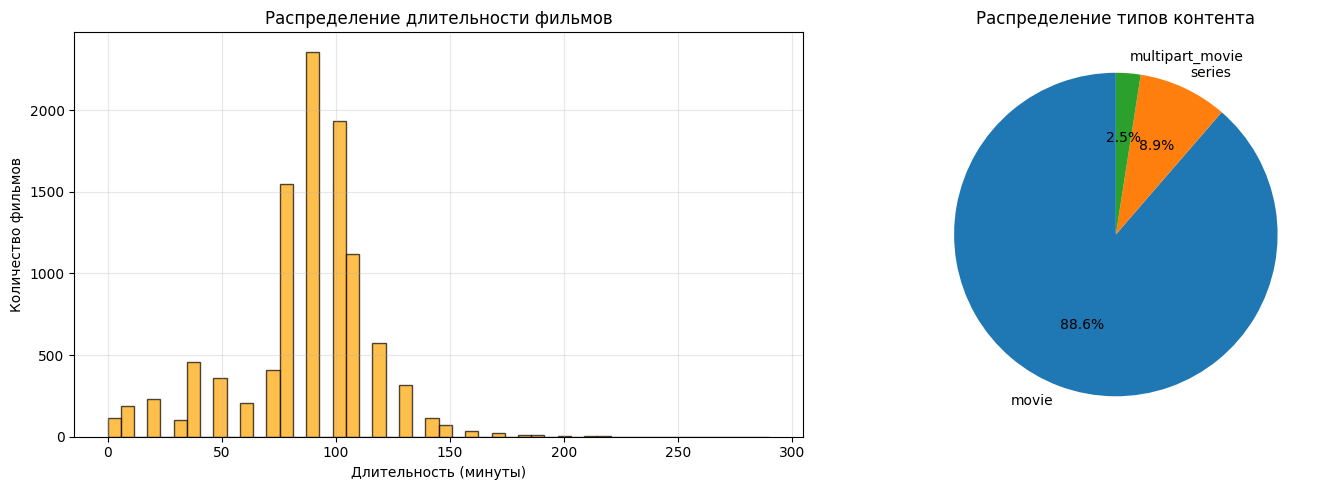

In [ ]:
def analyze_catalogue(catalogue):

    catalogue_df = pd.DataFrame.from_dict(catalogue, orient='index')
    catalogue_df.index = catalogue_df.index.astype(int)
    catalogue_df = catalogue_df.reset_index().rename(columns={'index': 'element_uid'})

    print(f"1. ОБЩАЯ ИНФОРМАЦИЯ:")
    print(f"   Всего фильмов в каталоге: {len(catalogue_df):,}")

    if 'type' in catalogue_df.columns:
        type_counts = catalogue_df['type'].value_counts()
        print(f"\n2. ТИПЫ КОНТЕНТА:")
        for content_type, count in type_counts.items():
            percentage = (count / len(catalogue_df)) * 100
            print(f"   {content_type}: {count:,} ({percentage:.1f}%)")

    if 'duration' in catalogue_df.columns:
        print(f"\n3.  ДЛИТЕЛЬНОСТЬ:")
        print(f"   Средняя длительность: {catalogue_df['duration'].mean():.1f} мин")
        print(f"   Медиана: {catalogue_df['duration'].median():.1f} мин")
        print(f"   Минимум: {catalogue_df['duration'].min()} мин")
        print(f"   Максимум: {catalogue_df['duration'].max()} мин")

        # квантили длительности
        duration_quantiles = catalogue_df['duration'].quantile([0.25, 0.5, 0.75, 0.9])
        print("   Распределение длительности:")
        for q, value in duration_quantiles.items():
            print(f"     {int(q*100)}%: {value:.1f} мин")

    if 'availability' in catalogue_df.columns:
        print(f"\n4. ДОСТУПНОСТЬ:")
        # Разворачиваем списки availability
        all_availability = []
        for avail_list in catalogue_df['availability'].dropna():
            if isinstance(avail_list, list):
                all_availability.extend(avail_list)

        availability_counts = pd.Series(all_availability).value_counts()
        for avail_type, count in availability_counts.items():
            percentage = (count / len(catalogue_df)) * 100
            print(f"   {avail_type}: {count:,} ({percentage:.1f}%)")

    # Анализ фичей
    feature_cols = [col for col in catalogue_df.columns if col.startswith('feature_')]
    if feature_cols:
        print(f"\n5. ФИЧИ КОНТЕНТА:")
        for feature in feature_cols[:5]:  # Показываем первые 5 фич
            if feature in catalogue_df.columns:
                print(f"   {feature}:")
                print(f"     Тип: {catalogue_df[feature].dtype}")
                print(f"     Уникальных значений: {catalogue_df[feature].nunique()}")
                if catalogue_df[feature].dtype in ['float64', 'int64']:
                    print(f"     Среднее: {catalogue_df[feature].mean():.3f}")
                    print(f"     Стандартное отклонение: {catalogue_df[feature].std():.3f}")

    # Визуализация каталога
    if 'duration' in catalogue_df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Распределение длительности
        axes[0].hist(catalogue_df['duration'], bins=50, alpha=0.7, color='orange', edgecolor='black')
        axes[0].set_title('Распределение длительности фильмов')
        axes[0].set_xlabel('Длительность (минуты)')
        axes[0].set_ylabel('Количество фильмов')
        axes[0].grid(True, alpha=0.3)

        # Распределение типов контента
        if 'type' in catalogue_df.columns:
            type_counts = catalogue_df['type'].value_counts()
            axes[1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
            axes[1].set_title('Распределение типов контента')

        plt.tight_layout()
        plt.show()

    return catalogue_df
print("АНАЛИЗ КАТАЛОГА ФИЛЬМОВ ")
catalogue_df = analyze_catalogue(catalogue)

In [ ]:
print("УДАЛЕНИЕ АНОМАЛИЙ ИЗ КАТАЛОГА")

# удаляем контент с нулевой и аномальной длительностью
catalogue_clean = catalogue_df[
    (catalogue_df['duration'] >= 10) &  # минимум 10 минут
    (catalogue_df['duration'] <= 240)   # максимум 4 часа
].copy()

# удаляем контент без доступных прав
catalogue_clean = catalogue_clean[
    catalogue_clean['availability'].apply(len) > 0
]

print(f"Исходный размер: {len(catalogue_df):,}")
print(f"После очистки: {len(catalogue_clean):,}")
print(f"Удалено записей: {len(catalogue_df) - len(catalogue_clean):,}")

# проверяем типы контента после очистки
print(f"\nТипы контента после очистки:")
print(catalogue_clean['type'].value_counts())

УДАЛЕНИЕ АНОМАЛИЙ ИЗ КАТАЛОГА
Исходный размер: 10,200
После очистки: 8,016
Удалено записей: 2,184

Типы контента после очистки:
type
movie              7213
series              681
multipart_movie     122
Name: count, dtype: int64


### Анализ дополнительных данных

In [ ]:
def analyze_additional_data(ratings, bookmarks, test_users):
    print(" АНАЛИЗ ДОПОЛНИТЕЛЬНЫХ ДАННЫХ ")

    if not ratings.empty:
        print("1.  ДАННЫЕ О РЕЙТИНГАХ:")
        print(f"   Всего оценок: {len(ratings):,}")
        print(f"   Уникальных пользователей: {ratings['user_uid'].nunique():,}")
        print(f"   Уникальных фильмов: {ratings['element_uid'].nunique():,}")


        rating_distribution = ratings['rating'].value_counts().sort_index()
        print(f"   Распределение оценок:")
        for rating, count in rating_distribution.items():
            percentage = (count / len(ratings)) * 100
            print(f"     {rating}: {count:,} ({percentage:.1f}%)")

        print(f"   Средняя оценка: {ratings['rating'].mean():.2f}")
        print(f"   Медиана оценки: {ratings['rating'].median():.2f}")

    if not bookmarks.empty:
        print(f"\n2.  ДАННЫЕ О ЗАКЛАДКАХ:")
        print(f"   Всего закладок: {len(bookmarks):,}")
        print(f"   Уникальных пользователей: {bookmarks['user_uid'].nunique():,}")
        print(f"   Уникальных фильмов: {bookmarks['element_uid'].nunique():,}")

        bookmarks_per_user = bookmarks.groupby('user_uid').size()
        print(f"   Среднее закладок на пользователя: {bookmarks_per_user.mean():.1f}")
        print(f"   Медиана закладок на пользователя: {bookmarks_per_user.median():.1f}")

analyze_additional_data(ratings, bookmarks, test_users)

 АНАЛИЗ ДОПОЛНИТЕЛЬНЫХ ДАННЫХ 
1.  ДАННЫЕ О РЕЙТИНГАХ:
   Всего оценок: 438,790
   Уникальных пользователей: 104,563
   Уникальных фильмов: 7,519
   Распределение оценок:
     0: 835 (0.2%)
     1: 1,685 (0.4%)
     2: 9,289 (2.1%)
     3: 4,647 (1.1%)
     4: 17,264 (3.9%)
     5: 15,711 (3.6%)
     6: 32,938 (7.5%)
     7: 35,343 (8.1%)
     8: 90,764 (20.7%)
     9: 62,810 (14.3%)
     10: 167,504 (38.2%)
   Средняя оценка: 8.19
   Медиана оценки: 9.00

2.  ДАННЫЕ О ЗАКЛАДКАХ:
   Всего закладок: 948,216
   Уникальных пользователей: 147,167
   Уникальных фильмов: 9,489
   Среднее закладок на пользователя: 6.4
   Медиана закладок на пользователя: 2.0


Используем стратегию по пользователям

In [ ]:
def create_correct_split(transactions, ratings, bookmarks, test_size=0.2):
    """Правильное разделение: test пользователи НЕ входят в train"""

    # находим общих пользователей
    trans_users = set(transactions['user_uid'])
    ratings_users = set(ratings['user_uid'])
    bookmarks_users = set(bookmarks['user_uid'])
    common_users = list(trans_users & ratings_users & bookmarks_users)

    print(f"Общие пользователи: {len(common_users):,}")

    # разделяем пользователей на train и test (НЕ пересекающиеся!)
    np.random.shuffle(common_users)

    n_test_users = int(len(common_users) * test_size)
    test_users = set(common_users[:n_test_users])        # Test пользователи
    train_users = set(common_users[n_test_users:])       # Train пользователи

    print(f"Train пользователей: {len(train_users):,}")
    print(f"Test пользователей: {len(test_users):,}")
    print(f"Общих пользователей: {len(train_users & test_users)} (должно быть 0)")

    # разделяем данные
    train_trans = transactions[transactions['user_uid'].isin(train_users)]
    test_trans = transactions[transactions['user_uid'].isin(test_users)]

    train_ratings = ratings[ratings['user_uid'].isin(train_users)]
    test_ratings = ratings[ratings['user_uid'].isin(test_users)]

    train_bookmarks = bookmarks[bookmarks['user_uid'].isin(train_users)]
    test_bookmarks = bookmarks[bookmarks['user_uid'].isin(test_users)]

    return train_trans, train_ratings, train_bookmarks, test_trans, test_ratings, test_bookmarks

In [ ]:
from collections import defaultdict

SIGNAL_WEIGHTS = {
    'bookmark': 1.0,    # самый сильный сигнал
    'rate': 0.8,        # сильный сигнал
    'watch': 0.6,       # базовый сигнал
}

ENGAGEMENT_WEIGHTS = {
    'all_three': 1.0,
    'watch_bookmark': 0.9,
    'watch_rate': 0.8,
    'watch_only': 0.7
}

N_NEGATIVES = 4

In [ ]:
def create_positive_examples(transactions, ratings, bookmarks):
    """Создание позитивных примеров с весами"""
    examples = []

    # просмотры
    watch_df = transactions[['user_uid', 'element_uid']].copy()
    watch_df['interaction_type'] = 'watch'
    watch_df['weight'] = SIGNAL_WEIGHTS['watch']
    examples.append(watch_df)

    # оценки (фильтруем низкие оценки)
    rate_df = ratings[ratings['rating'] >= 6][['user_uid', 'element_uid']].copy()
    rate_df['interaction_type'] = 'rate'
    rate_df['weight'] = SIGNAL_WEIGHTS['rate']
    examples.append(rate_df)

    # закладки
    bookmark_df = bookmarks[['user_uid', 'element_uid']].copy()
    bookmark_df['interaction_type'] = 'bookmark'
    bookmark_df['weight'] = SIGNAL_WEIGHTS['bookmark']
    examples.append(bookmark_df)

    return pd.concat(examples, ignore_index=True)

In [ ]:
def calculate_user_engagement(positive_examples):
    """Расчет уровня вовлеченности пользователей"""
    user_stats = positive_examples.groupby('user_uid')['interaction_type'].agg(['unique', 'count'])
    user_stats['engagement_tier'] = user_stats['unique'].apply(
        lambda x: ('all_three' if len(x) == 3 else
                  'watch_bookmark' if 'bookmark' in x and 'watch' in x else
                  'watch_rate' if 'rate' in x and 'watch' in x else
                  'watch_only')
    )
    user_stats['engagement_weight'] = user_stats['engagement_tier'].map(ENGAGEMENT_WEIGHTS)
    return user_stats[['engagement_tier', 'engagement_weight']].reset_index()

In [ ]:
def generate_negative_samples_fast(positive_examples, catalogue_clean, n_negatives=N_NEGATIVES):
    """генерация негативных примеров"""
    item_popularity = positive_examples['element_uid'].value_counts()
    user_positives = positive_examples.groupby('user_uid')['element_uid'].apply(set).to_dict()
    all_items = set(catalogue_clean['element_uid'])

    negative_examples = []

    print("Быстрая генерация негативных примеров...")
    for user, positives in tqdm(user_positives.items(), desc="Пользователи"):
        available_negatives = list(all_items - positives)
        if not available_negatives or len(available_negatives) < 10:
            continue

        n_samples = min(n_negatives, len(available_negatives) // 10)
        sampled_items = np.random.choice(available_negatives, size=n_samples, replace=False)

        for item in sampled_items:
            negative_examples.append({
                'user_uid': user,
                'element_uid': item,
                'interaction_type': 'negative',
                'weight': 1.0
            })

    return pd.DataFrame(negative_examples)

In [ ]:
def create_user_features(transactions, ratings, bookmarks):
    """Создание user features с сохранением оригинальных user_uid"""

    print("Создание user features...")

    # статистика по просмотрам
    user_watch_stats = transactions.groupby('user_uid').agg({
        'element_uid': ['count', 'nunique'],
        'watched_time': ['sum', 'mean', 'std'],
        'ts': ['min', 'max', 'std']
    }).round(3)

    user_watch_stats.columns = [
        'watch_count', 'unique_items', 'total_watch_time', 'mean_watch_time',
        'std_watch_time', 'first_ts', 'last_ts', 'ts_std'
    ]
    user_watch_stats['activity_duration'] = user_watch_stats['last_ts'] - user_watch_stats['first_ts']

    # статистика по оценкам
    user_rating_stats = ratings.groupby('user_uid').agg({
        'rating': ['count', 'mean', 'std']
    }).round(3)
    user_rating_stats.columns = ['rating_count', 'mean_rating', 'std_rating']

    # статистика по закладкам
    user_bookmark_stats = bookmarks.groupby('user_uid').agg({
        'element_uid': 'count'
    }).round(3)
    user_bookmark_stats.columns = ['bookmark_count']

    # объединение
    user_features = user_watch_stats
    for stats_df in [user_rating_stats, user_bookmark_stats]:
        user_features = user_features.merge(stats_df, left_index=True, right_index=True, how='left')

    user_features = user_features.fillna(0).reset_index()

    # сохраняем оригинальные user_uid как отдельную колонку
    user_features['user_uid_original'] = user_features['user_uid']

    # нормализация только числовых фич
    numeric_cols = [
        'watch_count', 'unique_items', 'total_watch_time', 'mean_watch_time',
        'std_watch_time', 'ts_std', 'activity_duration', 'rating_count',
        'mean_rating', 'std_rating', 'bookmark_count'
    ]

    scaler = StandardScaler()
    user_features[numeric_cols] = scaler.fit_transform(user_features[numeric_cols])

    # преобразование типов
    for col in numeric_cols:
        user_features[col] = user_features[col].astype(np.float32)

    print(f"Создано user features: {len(user_features):,} пользователей")
    return user_features


In [ ]:
def create_item_features(catalogue_clean):
    """Создание item features с сохранением оригинальных element_uid"""

    print("Создание item features...")
    item_features = catalogue_clean.copy()

    # сохраняем оригинальные element_uid как отдельную колонку
    item_features['element_uid_original'] = item_features['element_uid']

    # one-hot кодирование типа контента
    type_dummies = pd.get_dummies(item_features['type'], prefix='type')

    # one-hot кодирование availability
    availability_dummies = pd.get_dummies(
        item_features['availability'].explode()
    ).groupby(level=0).max().add_prefix('avail_')

    # нормализация числовых фич
    numeric_features = ['duration'] + [f'feature_{i}' for i in range(1, 6)]
    scaler = StandardScaler()
    item_features[numeric_features] = scaler.fit_transform(item_features[numeric_features])

    # объединение всех фич
    item_features = pd.concat([item_features, type_dummies, availability_dummies], axis=1)

    # выбираем финальные колонки
    feature_cols = numeric_features + list(type_dummies.columns) + list(availability_dummies.columns)

    result = item_features[['element_uid_original'] + feature_cols].copy()
    result = result.rename(columns={'element_uid_original': 'element_uid'})

    # преобразование типов
    for col in numeric_features:
        result[col] = pd.to_numeric(result[col], errors='coerce')
        result[col] = result[col].fillna(0).astype(np.float32)

    for col in type_dummies.columns:
        result[col] = result[col].fillna(0).astype(np.int8)

    for col in availability_dummies.columns:
        result[col] = result[col].fillna(0).astype(np.int8)

    print(f"Создано item features: {len(result):,} объектов")
    return result

In [ ]:
def create_training_data_optimized(transactions, ratings, bookmarks, catalogue_clean, sample_fraction=1.0):
    """создание датасета с балансировкой"""
    print("Создание оптимизированного датасета...")

    if sample_fraction < 1.0:
        all_users = transactions['user_uid'].unique()
        sampled_users = np.random.choice(all_users, size=int(len(all_users) * sample_fraction), replace=False)
        print(f"Выбрано {len(sampled_users):,} пользователей из {len(all_users):,}")

        transactions = transactions[transactions['user_uid'].isin(sampled_users)]
        ratings = ratings[ratings['user_uid'].isin(sampled_users)]
        bookmarks = bookmarks[bookmarks['user_uid'].isin(sampled_users)]


    print("Создание user features...")
    user_features = create_user_features(transactions, ratings, bookmarks)

    print("Создание item features...")
    item_features = create_item_features(catalogue_clean)


    print("Создание позитивных примеров...")
    positive_examples = create_positive_examples(transactions, ratings, bookmarks)


    print("Создание негативных примеров...")
    items_in_positives = set(positive_examples['element_uid'])
    catalogue_filtered = catalogue_clean[catalogue_clean['element_uid'].isin(items_in_positives)]
    negative_examples = generate_negative_samples_fast(positive_examples, catalogue_filtered)


    print("Объединение примеров...")
    all_examples = pd.concat([positive_examples, negative_examples], ignore_index=True)

    #  engagement веса
    user_engagement = calculate_user_engagement(positive_examples)
    all_examples = all_examples.merge(user_engagement[['user_uid', 'engagement_weight']], on='user_uid', how='left')
    all_examples['final_weight'] = all_examples['weight'] * all_examples['engagement_weight']
    all_examples['target'] = (all_examples['interaction_type'] != 'negative').astype(np.int8)

    print("Балансировка данных...")
    positive_mask = all_examples['target'] == 1
    negative_mask = all_examples['target'] == 0

    n_negative = negative_mask.sum()
    n_positive = positive_mask.sum()

    # балансируем до 50/50
    n_sample_positive = min(n_negative, n_positive)
    n_sample_negative = n_sample_positive

    negative_indices = np.random.choice(np.where(negative_mask)[0], size=n_sample_negative, replace=False)
    positive_indices = np.random.choice(np.where(positive_mask)[0], size=n_sample_positive, replace=False)

    balanced_indices = np.concatenate([positive_indices, negative_indices])
    balanced_data = all_examples.iloc[balanced_indices]

    print(f"После балансировки: {len(balanced_data):,} примеров")
    print(f"Распределение: {balanced_data['target'].mean()*100:.1f}% позитивных")

    print("Объединение с фичами...")
    needed_users = balanced_data['user_uid'].unique()
    needed_items = balanced_data['element_uid'].unique()

    user_features_filtered = user_features[user_features['user_uid'].isin(needed_users)]
    item_features_filtered = item_features[item_features['element_uid'].isin(needed_items)]

    train_data_with_features = balanced_data.merge(user_features_filtered, on='user_uid', how='left')
    train_data_with_features = train_data_with_features.merge(item_features_filtered, on='element_uid', how='left')

    print(f"\nФИНАЛЬНЫЙ ДАТАСЕТ:")
    print(f"Примеров: {len(train_data_with_features):,}")
    print(f"Уникальных пользователей: {train_data_with_features['user_uid'].nunique():,}")
    print(f"Уникальных товаров: {train_data_with_features['element_uid'].nunique():,}")

    return train_data_with_features, user_features, item_features

In [ ]:
def create_test_data_with_features(transactions, ratings, bookmarks, catalogue_clean, user_features, item_features):
    """Создание тестовых данных с проверкой"""
    print("ОБРАБОТКА ТЕСТОВЫХ ДАННЫХ")

    #  позитивные примеры для теста
    test_positive_examples = create_positive_examples(transactions, ratings, bookmarks)

    # только пользователи, которые есть в train
    test_users_in_train = set(test_positive_examples['user_uid']) & set(user_features['user_uid'])
    test_positive_examples = test_positive_examples[test_positive_examples['user_uid'].isin(test_users_in_train)]

    print(f"Тестовые позитивные примеры: {len(test_positive_examples):,}")
    print(f"Тестовые пользователи: {len(test_users_in_train):,}")

    # если нет данных - возвращаем пустой датафрейм
    if len(test_positive_examples) == 0:
        print(" ВНИМАНИЕ: Нет общих пользователей между train и test!")
        # пустой датафрейм с правильными колонками
        empty_df = pd.DataFrame(columns=['user_uid', 'element_uid', 'interaction_type', 'weight',
                                       'engagement_weight', 'final_weight', 'target'])
        return empty_df

    # создаем негативные примеры для теста
    test_negative_examples = generate_negative_samples_fast(test_positive_examples, catalogue_clean, n_negatives=2)

    # объединяем тестовые примеры
    test_data = pd.concat([test_positive_examples, test_negative_examples], ignore_index=True)

    # добавляем engagement веса
    test_user_engagement = calculate_user_engagement(test_positive_examples)
    test_data = test_data.merge(test_user_engagement[['user_uid', 'engagement_weight']], on='user_uid')
    test_data['final_weight'] = test_data['weight'] * test_data['engagement_weight']
    test_data['target'] = (test_data['interaction_type'] != 'negative').astype(int)

    # объединяем с фичами
    test_data_with_features = test_data.merge(user_features, on='user_uid', how='inner')
    test_data_with_features = test_data_with_features.merge(item_features, on='element_uid', how='inner')

    print(f"Тестовый датасет: {len(test_data_with_features):,} примеров")


    if len(test_negative_examples) > 0:
        print(f"Соотношение позитивных/негативных: {len(test_positive_examples)/len(test_negative_examples):.2f}:1")
    else:
        print("Соотношение позитивных/негативных: только позитивные примеры")

    return test_data_with_features

In [ ]:
def prepare_data_for_model(train_data, user_features, item_features):

    print("Подготовка данных для модели...")

    # маппинги из оригинальных ID в индексы
    unique_users = train_data['user_uid'].unique()
    unique_items = train_data['element_uid'].unique()

    user_to_index = {uid: idx for idx, uid in enumerate(unique_users)}
    item_to_index = {iid: idx for idx, iid in enumerate(unique_items)}

    print(f"Создано маппингов:")
    print(f"  Пользователей: {len(user_to_index):,}")
    print(f"  Товаров: {len(item_to_index):,}")

    # User features (исключаем user_uid)
    user_feature_cols = [col for col in user_features.columns if col not in ['user_uid', 'user_uid_original']]
    item_feature_cols = [col for col in item_features.columns if col != 'element_uid']

    # массивы данных
    X_user_data = []
    X_item_data = []
    y_data = []
    weights_data = []

    print("Формирование фичей...")
    for _, row in tqdm(train_data.iterrows(), total=len(train_data)):
        user_idx = user_to_index[row['user_uid']]
        item_idx = item_to_index[row['element_uid']]

        # User features
        user_mask = user_features['user_uid'] == row['user_uid']
        if user_mask.any():
            user_feats = user_features[user_mask][user_feature_cols].iloc[0].values
        else:
            user_feats = np.zeros(len(user_feature_cols))

        # Item features
        item_mask = item_features['element_uid'] == row['element_uid']
        if item_mask.any():
            item_feats = item_features[item_mask][item_feature_cols].iloc[0].values
        else:
            item_feats = np.zeros(len(item_feature_cols))

        # добавляем индекс как первый признак
        user_vector = np.concatenate([[user_idx], user_feats])
        item_vector = np.concatenate([[item_idx], item_feats])

        X_user_data.append(user_vector)
        X_item_data.append(item_vector)
        y_data.append(row['target'])
        weights_data.append(row['final_weight'])

    X_user = np.array(X_user_data)
    X_item = np.array(X_item_data)
    y = np.array(y_data)
    weights = np.array(weights_data)

    print(f"\nФИНАЛЬНЫЕ ДАННЫЕ ДЛЯ МОДЕЛИ:")
    print(f"X_user: {X_user.shape}")
    print(f"X_item: {X_item.shape}")
    print(f"y: {y.shape}")
    print(f"Уникальных user_idx: {len(np.unique(X_user[:, 0]))}")
    print(f"Уникальных item_idx: {len(np.unique(X_item[:, 0]))}")
    print(f"Диапазон user_idx: {X_user[:, 0].min()} - {X_user[:, 0].max()}")
    print(f"Диапазон item_idx: {X_item[:, 0].min()} - {X_item[:, 0].max()}")

    return X_user, X_item, y, weights, user_to_index, item_to_index

In [ ]:
def clean_data_completely(X_user, X_item, y, weights):

    # проверяем на NaN и Inf
    user_nan_mask = np.any(np.isnan(X_user), axis=1)
    item_nan_mask = np.any(np.isnan(X_item), axis=1)
    user_inf_mask = np.any(np.isinf(X_user), axis=1)
    item_inf_mask = np.any(np.isinf(X_item), axis=1)

    # общая маска проблемных строк
    bad_mask = user_nan_mask | item_nan_mask | user_inf_mask | item_inf_mask
    good_mask = ~bad_mask

    print(f"Обнаружено проблемных строк: {bad_mask.sum():,}")
    print(f"Хороших строк: {good_mask.sum():,}")


    X_user_clean = X_user[good_mask]
    X_item_clean = X_item[good_mask]
    y_clean = y[good_mask]
    weights_clean = weights[good_mask]

    print(f"После очистки:")
    print(f"  NaN в X_user: {np.isnan(X_user_clean).sum()}")
    print(f"  NaN в X_item: {np.isnan(X_item_clean).sum()}")
    print(f"  Inf в X_user: {np.isinf(X_user_clean).sum()}")
    print(f"  Inf в X_item: {np.isinf(X_item_clean).sum()}")

    return X_user_clean, X_item_clean, y_clean, weights_clean


In [ ]:
def balance_training_data_improved(X_user, X_item, y, weights, target_positive_ratio=0.5):
    positive_mask = y == 1
    negative_mask = y == 0

    n_positive = int(np.sum(positive_mask))
    n_negative = int(np.sum(negative_mask))

    print(f"АНАЛИЗ ДИСБАЛАНСА:")
    print(f"Позитивных примеров: {n_positive:,} ({n_positive/len(y)*100:.1f}%)")
    print(f"Негативных примеров: {n_negative:,} ({n_negative/len(y)*100:.1f}%)")
    print(f"Исходный ratio: {n_positive/len(y):.3f}")

    # рассчитываем нужное количество примеров каждого класса
    if n_positive > n_negative:
        major_class = 'positive'
        major_count = n_positive
        minor_count = n_negative
        target_major_count = int(minor_count * (1 - target_positive_ratio) / target_positive_ratio)
    else:
        major_class = 'negative'
        major_count = n_negative
        minor_count = n_positive
        target_major_count = int(minor_count * target_positive_ratio / (1 - target_positive_ratio))

    print(f"Мажоритарный класс: {major_class}")
    print(f"Целевой positive ratio: {target_positive_ratio}")

    # балансируем данные
    if major_class == 'positive':
        # уменьшаем позитивные примеры
        positive_indices = np.where(positive_mask)[0]
        if target_major_count < n_positive:
            selected_positive_indices = np.random.choice(
                positive_indices,
                size=target_major_count,
                replace=False
            )
        else:
            selected_positive_indices = positive_indices

        # берем все негативные примеры
        negative_indices = np.where(negative_mask)[0]
        selected_negative_indices = negative_indices

    else:
        # уменьшаем негативные примеры
        negative_indices = np.where(negative_mask)[0]
        if target_major_count < n_negative:
            selected_negative_indices = np.random.choice(
                negative_indices,
                size=target_major_count,
                replace=False
            )
        else:
            selected_negative_indices = negative_indices

        # берем все позитивные примеры
        positive_indices = np.where(positive_mask)[0]
        selected_positive_indices = positive_indices

    # объединяем выбранные индексы
    selected_indices = np.concatenate([selected_positive_indices, selected_negative_indices])

    X_user_bal = X_user[selected_indices]
    X_item_bal = X_item[selected_indices]
    y_bal = y[selected_indices]
    weights_bal = weights[selected_indices]

    n_positive_after = np.sum(y_bal == 1)
    n_negative_after = np.sum(y_bal == 0)

    print(f"РЕЗУЛЬТАТ БАЛАНСИРОВКИ:")
    print(f"Позитивных примеров после балансировки: {n_positive_after:,}")
    print(f"Негативных примеров после балансировки: {n_negative_after:,}")
    print(f"Положительный ratio после балансировки: {n_positive_after / len(y_bal):.3f}")
    print(f"Общий размер после балансировки: {len(y_bal):,}")

    return X_user_bal, X_item_bal, y_bal, weights_bal

In [ ]:
def create_validation_data(X_user, X_item, y, weights, val_size=0.1):
    """Правильное разделение: сначала по пользователям, потом балансировка"""


    user_ids = X_user[:, 0].astype(int)
    unique_users = np.unique(user_ids)

    # разделяем пользователей
    n_val_users = max(1, int(len(unique_users) * val_size))
    val_users = np.random.choice(unique_users, size=n_val_users, replace=False)

    # создаем маски
    train_mask = ~np.isin(user_ids, val_users)
    val_mask = np.isin(user_ids, val_users)

    # разделяем данные
    X_train_user = X_user[train_mask]
    X_train_item = X_item[train_mask]
    y_train = y[train_mask]
    weights_train = weights[train_mask]

    X_val_user = X_user[val_mask]
    X_val_item = X_item[val_mask]
    y_val = y[val_mask]
    weights_val = weights[val_mask]

    print(f"Результат разделения:")
    print(f"  Train: {len(X_train_user):,} примеров, {len(np.unique(X_train_user[:, 0])):,} пользователей")
    print(f"  Val: {len(X_val_user):,} примеров, {len(np.unique(X_val_user[:, 0])):,} пользователей")

    # проверяем что нет общих пользователей
    train_users = set(np.unique(X_train_user[:, 0]))
    val_users_set = set(np.unique(X_val_user[:, 0]))
    common_users = train_users & val_users_set

    if len(common_users) > 0:
        print(f" ОШИБКА: {len(common_users)} общих пользователей!")
    else:
        print(" Нет общих пользователей")

    return (X_train_user, X_train_item, y_train, weights_train,
            X_val_user, X_val_item, y_val, weights_val)


# Two-tower архитектура

In [ ]:
class NDCGCallback(tf.keras.callbacks.Callback):
    """Callback для вычисления NDCG с фильтрацией"""
    def __init__(self, X_val_input, y_val, k=10):
        super().__init__()
        self.X_val_input = X_val_input
        self.y_val = y_val
        self.k = k
        self.ndcg_scores = []

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.X_val_input, verbose=0).flatten()
        ndcg = self.calculate_ndcg_correct(predictions, self.y_val, self.k)
        self.ndcg_scores.append(ndcg)
        logs = logs or {}
        logs[f'ndcg@{self.k}'] = ndcg
        print(f" - NDCG@{self.k}: {ndcg:.4f}")

    def calculate_ndcg_correct(self, predictions, y_true, k):
        user_ids = self.X_val_input[0].flatten()
        unique_users = np.unique(user_ids)
        ndcg_scores = []

        for user in unique_users:
            user_mask = user_ids == user
            user_scores = predictions[user_mask]
            user_labels = y_true[user_mask]

            # ФИЛЬТР: только пользователи с позитивными взаимодействиями
            total_relevant = np.sum(user_labels)
            if total_relevant < 1:
                continue

            if len(user_scores) < 2:
                continue

            sorted_indices = np.argsort(user_scores)[::-1]
            sorted_labels = user_labels[sorted_indices]

            top_k = min(k, len(sorted_labels))
            top_k_labels = sorted_labels[:top_k]

            dcg = 0
            for i, label in enumerate(top_k_labels):
                dcg += label / np.log2(i + 2)

            ideal_sorted = np.sort(user_labels)[::-1][:top_k]
            idcg = 0
            for i, label in enumerate(ideal_sorted):
                idcg += label / np.log2(i + 2)

            if idcg > 0:
                ndcg_scores.append(dcg / idcg)

        return np.mean(ndcg_scores) if ndcg_scores else 0

In [ ]:
def build_two_tower_model(num_users, num_items, user_features_dim, item_features_dim, embedding_dim=64):
    """Двубашенная архитектура"""

    # USER TOWER
    user_id_input = Input(shape=(1,), name='user_id_input')
    user_features_input = Input(shape=(user_features_dim,), name='user_features_input')

    user_embedding = Embedding(num_users, embedding_dim, name='user_embedding')(user_id_input)
    user_embedding = Flatten()(user_embedding)

    if user_features_dim > 0:
        user_features_dense = Dense(32, activation='relu')(user_features_input)
        user_features_dense = BatchNormalization()(user_features_dense)
        user_combined = Concatenate()([user_embedding, user_features_dense])
    else:
        user_combined = user_embedding

    user_tower = Dense(64, activation='relu')(user_combined)
    user_tower = BatchNormalization()(user_tower)
    user_tower = Dropout(0.3)(user_tower)
    user_tower = Dense(32, activation='relu', name='user_embedding_output')(user_tower)

    # ITEM TOWER
    item_id_input = Input(shape=(1,), name='item_id_input')
    item_features_input = Input(shape=(item_features_dim,), name='item_features_input')

    item_embedding = Embedding(num_items, embedding_dim, name='item_embedding')(item_id_input)
    item_embedding = Flatten()(item_embedding)

    if item_features_dim > 0:
        item_features_dense = Dense(32, activation='relu')(item_features_input)
        item_features_dense = BatchNormalization()(item_features_dense)
        item_combined = Concatenate()([item_embedding, item_features_dense])
    else:
        item_combined = item_embedding

    item_tower = Dense(64, activation='relu')(item_combined)
    item_tower = BatchNormalization()(item_tower)
    item_tower = Dropout(0.3)(item_tower)
    item_tower = Dense(32, activation='relu', name='item_embedding_output')(item_tower)

    # INTERACTION
    dot_product = Dot(axes=1, normalize=False)([user_tower, item_tower])
    output = Dense(1, activation='sigmoid', name='output')(dot_product)

    model = Model(
        inputs=[user_id_input, user_features_input, item_id_input, item_features_input],
        outputs=output
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    return model

In [ ]:
def prepare_two_tower_data(X_user, X_item):
    """Подготовка данных для двубашенной архитектуры"""
    if X_user.shape[1] > 1:
        user_ids = X_user[:, 0].astype(int)
        user_features = X_user[:, 1:]
    else:
        user_ids = X_user[:, 0].astype(int)
        user_features = np.zeros((len(X_user), 0))

    if X_item.shape[1] > 1:
        item_ids = X_item[:, 0].astype(int)
        item_features = X_item[:, 1:]
    else:
        item_ids = X_item[:, 0].astype(int)
        item_features = np.zeros((len(X_item), 0))

    return user_ids, user_features, item_ids, item_features

In [ ]:
def train_with_early_stopping_fixed(model, X_train, X_val, y_train, y_val, epochs=10, batch_size=512):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss',
        min_delta=0.001,
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )

    ndcg_callback = NDCGCallback(X_val, y_val, k=10)
    callbacks = [early_stopping, reduce_lr, ndcg_callback]

    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )

    return history, ndcg_callback.ndcg_scores

In [ ]:
def calculate_ranking_metrics_correct(model, X_data, y_true, k_values=[5, 10, 20]):
    predictions = model.predict(X_data, verbose=0).flatten()

    if isinstance(X_data, (list, tuple)) and len(X_data) > 0:
        user_ids = X_data[0].flatten()
    else:
        user_ids = np.arange(len(predictions))

    unique_users = np.unique(user_ids)

    recall_at_k = {k: [] for k in k_values}
    precision_at_k = {k: [] for k in k_values}
    ndcg_at_k = {k: [] for k in k_values}
    average_precision = []

    for user in unique_users:
        user_mask = user_ids == user
        user_scores = predictions[user_mask]
        user_labels = y_true[user_mask]

        # ФИЛЬТР: только пользователи с позитивными взаимодействиями
        total_relevant = np.sum(user_labels)
        if total_relevant < 1:
            continue

        if len(user_scores) < 2:
            continue

        sorted_indices = np.argsort(user_scores)[::-1]
        sorted_labels = user_labels[sorted_indices]

        for k in k_values:
            top_k = min(k, len(sorted_labels))
            top_k_labels = sorted_labels[:top_k]
            relevant_in_top_k = np.sum(top_k_labels)

            recall_at_k[k].append(relevant_in_top_k / total_relevant)
            precision_at_k[k].append(relevant_in_top_k / top_k)

            # NDCG расчет
            dcg = 0
            for i, label in enumerate(top_k_labels):
                dcg += label / np.log2(i + 2)

            ideal_sorted = np.sort(user_labels)[::-1][:top_k]
            idcg = 0
            for i, label in enumerate(ideal_sorted):
                idcg += label / np.log2(i + 2)

            ndcg_at_k[k].append(dcg / idcg if idcg > 0 else 0)

        # Average Precision
        relevant_positions = np.where(sorted_labels == 1)[0] + 1
        precisions_at_k = []
        for i, pos in enumerate(relevant_positions):
            precisions_at_k.append((i + 1) / pos)
        average_precision.append(np.mean(precisions_at_k) if precisions_at_k else 0)

    metrics = {}
    for k in k_values:
        metrics[f'recall@{k}'] = np.mean(recall_at_k[k]) if recall_at_k[k] else 0
        metrics[f'precision@{k}'] = np.mean(precision_at_k[k]) if precision_at_k[k] else 0
        metrics[f'ndcg@{k}'] = np.mean(ndcg_at_k[k]) if ndcg_at_k[k] else 0

    metrics['map'] = np.mean(average_precision) if average_precision else 0

    return metrics

In [ ]:
def print_recommendation_metrics(ranking_metrics, history):
    """Вывод метрик рекомендательной системы"""
    print("\nМЕТРИКИ РЕКОМЕНДАТЕЛЬНОЙ СИСТЕМЫ:")

    print("Recall Metrics:")
    for k in [5, 10, 20]:
        print(f"  Recall@{k}: {ranking_metrics.get(f'recall@{k}', 0):.4f}")

    print("\nPrecision Metrics:")
    for k in [5, 10, 20]:
        print(f"  Precision@{k}: {ranking_metrics.get(f'precision@{k}', 0):.4f}")

    print("\nNDCG Metrics:")
    for k in [5, 10, 20]:
        print(f"  NDCG@{k}: {ranking_metrics.get(f'ndcg@{k}', 0):.4f}")

    print(f"\nMAP: {ranking_metrics.get('map', 0):.4f}")
    print(f"Final Val Loss: {history.history['val_loss'][-1]:.4f}")

In [ ]:
def plot_recommendation_results(history, ranking_metrics):
    """Визуализация результатов рекомендательной системы"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0,0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0,0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0,0].set_title('Training and Validation Loss')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Recall@K
    k_values = [5, 10, 20]
    recall_values = [ranking_metrics.get(f'recall@{k}', 0) for k in k_values]
    bars1 = axes[0,1].bar([f'R@{k}' for k in k_values], recall_values,
                         color=['skyblue', 'lightblue', 'steelblue'], alpha=0.8)
    axes[0,1].set_title('Recall@K Metrics')
    axes[0,1].set_ylabel('Score')
    for bar, value in zip(bars1, recall_values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom')

    # NDCG@K
    ndcg_values = [ranking_metrics.get(f'ndcg@{k}', 0) for k in k_values]
    bars2 = axes[1,0].bar([f'NDCG@{k}' for k in k_values], ndcg_values,
                         color=['lightcoral', 'coral', 'red'], alpha=0.8)
    axes[1,0].set_title('NDCG@K Metrics')
    axes[1,0].set_ylabel('Score')
    for bar, value in zip(bars2, ndcg_values):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom')

    # MAP и Precision
    summary_metrics = ['MAP', 'Precision@10', 'Precision@20']
    summary_values = [
        ranking_metrics.get('map', 0),
        ranking_metrics.get('precision@10', 0),
        ranking_metrics.get('precision@20', 0)
    ]
    colors = ['gold', 'lightgreen', 'darkgreen']

    bars3 = axes[1,1].bar(summary_metrics, summary_values, color=colors, alpha=0.8)
    axes[1,1].set_title('Summary Metrics')
    axes[1,1].set_ylabel('Score')
    for bar, value in zip(bars3, summary_values):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [ ]:
def two_tower_pipeline_fixed(X_train_user, X_train_item, y_train, sample_weights_train):

    print("Очистка данных от NaN и Inf...")
    X_train_user_clean, X_train_item_clean, y_train_clean, sample_weights_clean = clean_data_completely(
        X_train_user, X_train_item, y_train, sample_weights_train
    )

    #  разделение на train/val
    print("Создание валидационных данных...")
    (X_train_split, X_item_train_split, y_train_split, weights_train_split,
     X_val_user, X_val_item, y_val, sample_weights_val) = create_validation_data(
        X_train_user_clean, X_train_item_clean, y_train_clean, sample_weights_clean, val_size=0.1
    )


    X_train_bal, X_item_bal, y_train_bal, weights_train_bal = X_train_split, X_item_train_split, y_train_split, weights_train_split

    num_users = int(np.max(X_train_bal[:, 0]) + 1) if X_train_bal.shape[1] > 1 else len(np.unique(X_train_bal))
    num_items = int(np.max(X_item_bal[:, 0]) + 1) if X_item_bal.shape[1] > 1 else len(np.unique(X_item_bal))

    user_features_dim = X_train_bal.shape[1] - 1 if X_train_bal.shape[1] > 1 else 0
    item_features_dim = X_item_bal.shape[1] - 1 if X_item_bal.shape[1] > 1 else 0

    print(f"ИСПРАВЛЕННЫЙ ПАЙПЛАЙН:")
    print(f"Количество пользователей: {num_users}")
    print(f"Количество товаров: {num_items}")
    print(f"Train размер: {len(y_train_bal):,}")
    print(f"Val размер: {len(y_val):,}")
    print(f"Позитивных в train: {np.sum(y_train_bal):,} ({np.mean(y_train_bal)*100:.1f}%)")
    print(f"Позитивных в val: {np.sum(y_val):,} ({np.mean(y_val)*100:.1f}%)")

    # подготовка данных
    print("Подготовка данных для двубашенной архитектуры...")
    train_user_ids, train_user_features, train_item_ids, train_item_features = prepare_two_tower_data(X_train_bal, X_item_bal)
    val_user_ids, val_user_features, val_item_ids, val_item_features = prepare_two_tower_data(X_val_user, X_val_item)


    print("Создание ДВУБАШЕННОЙ модели...")
    model = build_two_tower_model(
        num_users=num_users,
        num_items=num_items,
        user_features_dim=user_features_dim,
        item_features_dim=item_features_dim,
        embedding_dim=64
    )

    # входные данные
    X_train_input = [train_user_ids, train_user_features, train_item_ids, train_item_features]
    X_val_input = [val_user_ids, val_user_features, val_item_ids, val_item_features]

    # обучение с callback
    print("Обучение двубашенной модели...")
    history, ndcg_history = train_with_early_stopping_fixed(
        model, X_train_input, X_val_input, y_train_bal, y_val,
        epochs=15, batch_size=512
    )


    print("\nОЦЕНКА МОДЕЛИ:")
    ranking_metrics = calculate_ranking_metrics_correct(model, X_val_input, y_val)
    print_recommendation_metrics(ranking_metrics, history)

    # график NDCG во время обучения
    if ndcg_history:
        plt.figure(figsize=(10, 4))
        plt.plot(ndcg_history, marker='o', linewidth=2)
        plt.title('NDCG@10 во время обучения')
        plt.xlabel('Эпоха')
        plt.ylabel('NDCG@10')
        plt.grid(True, alpha=0.3)
        plt.show()

    plot_recommendation_results(history, ranking_metrics)

    return model, history, ranking_metrics, ndcg_history

---------------------------------------------------------------------------------

ЗАПУСК ПОЛНОГО ПАЙПЛАЙНА РЕКОМЕНДАТЕЛЬНОЙ СИСТЕМЫ

1. РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/TEST...
Всего пользователей в transactions: 499,663
Train пользователей: 399,731
Test пользователей: 99,932
Общих пользователей: 0

Train данные:
  Просмотры: 7,722,988
  Оценки: 348,843
  Закладки: 757,183

Test данные:
  Просмотры: 1,920,024
  Оценки: 86,346
  Закладки: 188,356
✓ Train данные:
  • Просмотры: 7,722,988
  • Оценки: 348,843
  • Закладки: 757,183

2. СОЗДАНИЕ ТРЕНИРОВОЧНЫХ ДАННЫХ...
Создание оптимизированного датасета...
Выбрано 39,973 пользователей из 399,731
Создание user features...
Создание user features...
Создано user features: 39,973 пользователей
Создание item features...
Создание item features...
Создано item features: 8,016 объектов
Создание позитивных примеров...
Создание негативных примеров...
Быстрая генерация негативных примеров...


Пользователи: 100%|██████████| 39973/39973 [00:50<00:00, 796.67it/s]


Объединение примеров...
Балансировка данных...
После балансировки: 319,784 примеров
Распределение: 50.0% позитивных
Объединение с фичами...

ФИНАЛЬНЫЙ ДАТАСЕТ:
Примеров: 319,784
Уникальных пользователей: 39,973
Уникальных товаров: 8,001

3. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИ...
Подготовка данных для модели...
Создано маппингов:
  Пользователей: 39,973
  Товаров: 8,001
Формирование фичей...


100%|██████████| 319784/319784 [14:22<00:00, 370.90it/s]



ФИНАЛЬНЫЕ ДАННЫЕ ДЛЯ МОДЕЛИ:
X_user: (319784, 14)
X_item: (319784, 13)
y: (319784,)
Уникальных user_idx: 39973
Уникальных item_idx: 8001
Диапазон user_idx: 0.0 - 39972.0
Диапазон item_idx: 0.0 - 8000.0

4. ОБУЧЕНИЕ ДВУБАШЕННОЙ МОДЕЛИ...
Очистка данных от NaN и Inf...
Обнаружено проблемных строк: 0
Хороших строк: 319,784
После очистки:
  NaN в X_user: 0
  NaN в X_item: 0
  Inf в X_user: 0
  Inf в X_item: 0
Создание валидационных данных...
Результат разделения:
  Train: 287,033 примеров, 35,976 пользователей
  Val: 32,751 примеров, 3,997 пользователей
 Нет общих пользователей
ИСПРАВЛЕННЫЙ ПАЙПЛАЙН:
Количество пользователей: 39973
Количество товаров: 8001
Train размер: 287,033
Val размер: 32,751
Позитивных в train: 143,129 (49.9%)
Позитивных в val: 16,763 (51.2%)
Подготовка данных для двубашенной архитектуры...
Создание ДВУБАШЕННОЙ модели...
Обучение двубашенной модели...
Epoch 1/15
560/561 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.2648 - NDCG@10: 0.8256
561/561 ━━━━━━━━━━━━━━━━━━━━ 29

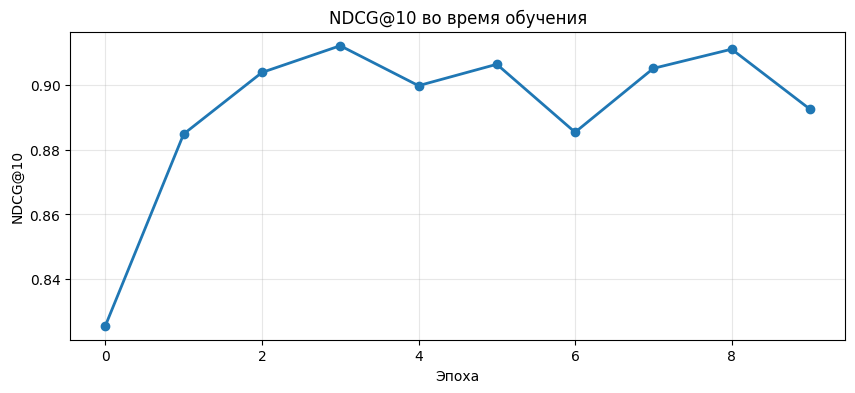

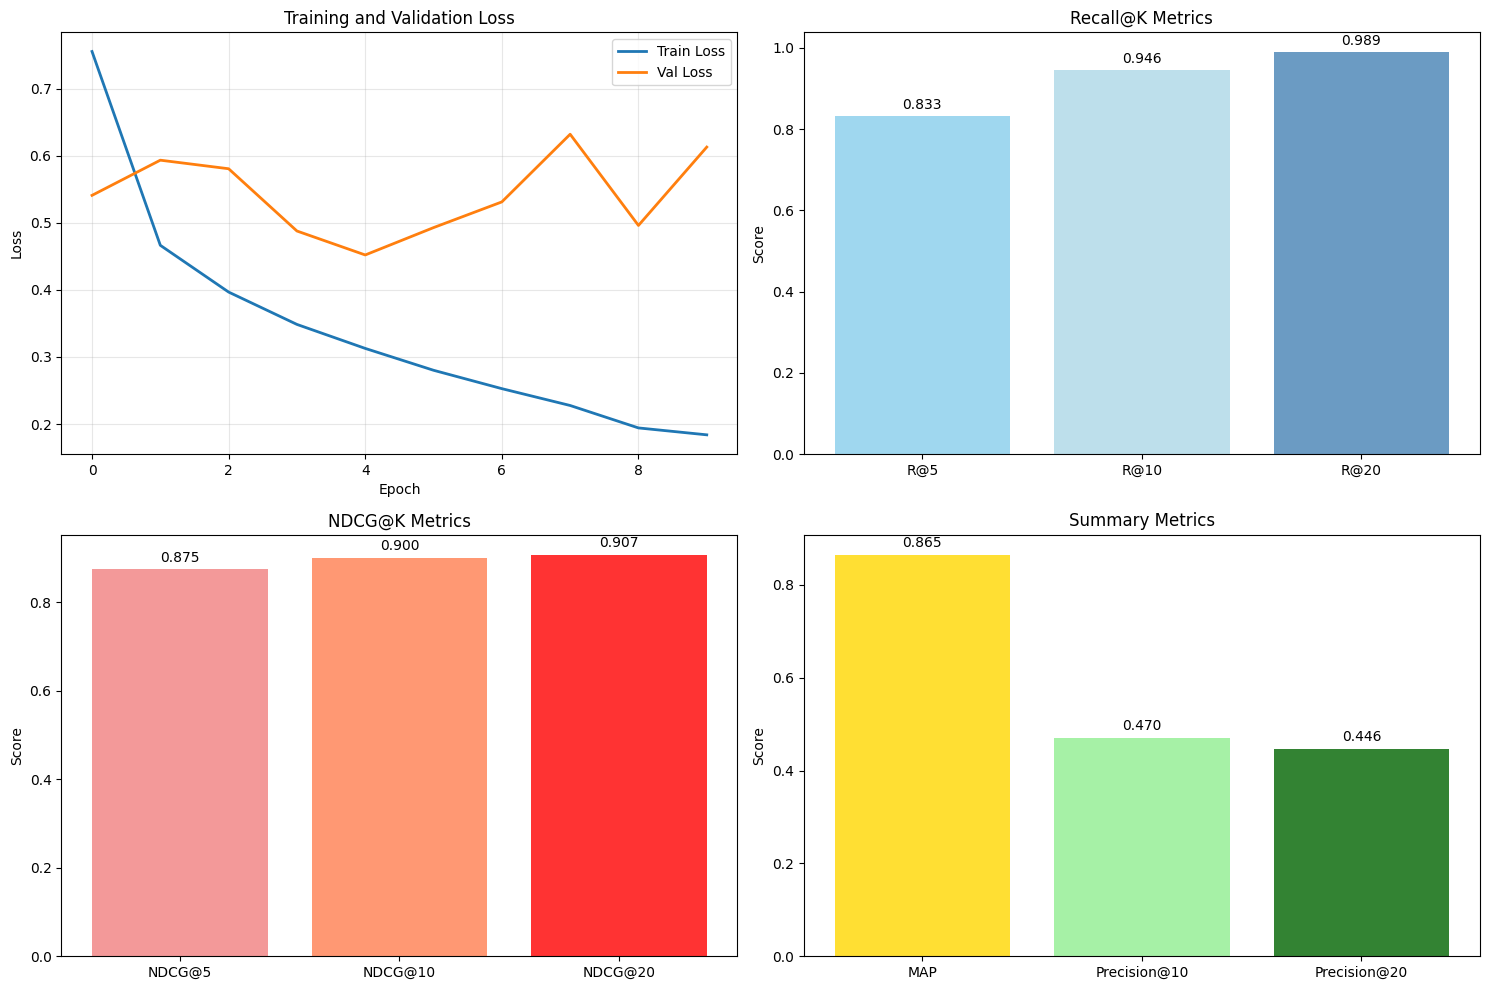

ОБУЧЕНИЕ ЗАВЕРШЕНО!


In [ ]:
print("\n1. РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/TEST...")
train_trans, train_ratings, train_bookmarks, test_trans, test_ratings, test_bookmarks = create_correct_split(
    transactions, ratings, bookmarks, test_size=0.2
)

print(f"✓ Train данные:")
print(f"  • Просмотры: {len(train_trans):,}")
print(f"  • Оценки: {len(train_ratings):,}")
print(f"  • Закладки: {len(train_bookmarks):,}")

print("\n2. СОЗДАНИЕ ТРЕНИРОВОЧНЫХ ДАННЫХ...")
train_data, user_features, item_features = create_training_data_optimized(
    train_trans, train_ratings, train_bookmarks, catalogue_clean, sample_fraction=0.1  # начинаем с 10% данных для скорости
)

print("\n3. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИ...")
X_train_user, X_train_item, y_train, sample_weights_train, user_to_index, item_to_index = prepare_data_for_model(
    train_data, user_features, item_features
)

print("\n4. ОБУЧЕНИЕ ДВУБАШЕННОЙ МОДЕЛИ...")
model, history, metrics, ndcg_history = two_tower_pipeline_fixed(
    X_train_user, X_train_item, y_train, sample_weights_train
)


# Примеры альтернативных функций потерь для рекомендательных систем

## 1. Triplet Loss (Тройная функция потерь)

```python
def build_two_tower_triplet_model(num_users, num_items, user_features_dim, item_features_dim, embedding_dim=64):
    """Двубашенная модель с Triplet Loss"""
    
    # якорь (anchor) - пользователь
    user_input = Input(shape=(1,), name='user_input')
    user_features_input = Input(shape=(user_features_dim,), name='user_features_input')
    
    # позитивный и негативный товары
    positive_item_input = Input(shape=(1,), name='positive_item_input')
    positive_item_features = Input(shape=(item_features_dim,), name='positive_item_features')
    
    negative_item_input = Input(shape=(1,), name='negative_item_input')
    negative_item_features = Input(shape=(item_features_dim,), name='negative_item_features')
    
    # общие башни для пользователей и товаров
    user_tower = build_user_tower(num_users, user_features_dim, embedding_dim)
    item_tower = build_item_tower(num_items, item_features_dim, embedding_dim)
    
    # эмбеддинги для тройки
    user_embedding = user_tower([user_input, user_features_input])
    positive_embedding = item_tower([positive_item_input, positive_item_features])
    negative_embedding = item_tower([negative_item_input, negative_item_features])
    
    # triplet loss вычисляется как часть модели
    positive_similarity = Dot(axes=1, normalize=True)([user_embedding, positive_embedding])
    negative_similarity = Dot(axes=1, normalize=True)([user_embedding, negative_embedding])
    
    # разность сходств для triplet loss
    loss = negative_similarity - positive_similarity
    
    model = Model(
        inputs=[
            user_input, user_features_input,
            positive_item_input, positive_item_features,
            negative_item_input, negative_item_features
        ],
        outputs=loss
    )
    
    # triplet loss с margin
    def triplet_loss(y_true, y_pred):
        margin = 0.2
        return tf.maximum(y_pred + margin, 0.0)
    
    model.compile(optimizer='adam', loss=triplet_loss)
    return model

def generate_triplet_data(X_user, X_item, y, num_negatives=4):
    """Генерация троек для обучения"""
    triplets = []
    
    for i in range(len(X_user)):
        if y[i] == 1:  # nолько позитивные взаимодействия
            user_data = X_user[i]
            positive_item = X_item[i]
            
            # находим негативные примеры
            negative_indices = np.where(y == 0)[0]
            selected_negatives = np.random.choice(negative_indices, num_negatives, replace=False)
            
            for neg_idx in selected_negatives:
                negative_item = X_item[neg_idx]
                triplets.append((user_data, positive_item, negative_item))
    
    return triplets
```

## 2. BPR Loss (Bayesian Personalized Ranking)

```python
def build_two_tower_bpr_model(num_users, num_items, user_features_dim, item_features_dim, embedding_dim=64):
    """Двубашенная модель с BPR Loss"""
    
    # входы: пользователь, позитивный товар, негативный товар
    user_input = Input(shape=(1,), name='user_input')
    user_features_input = Input(shape=(user_features_dim,), name='user_features_input')
    
    positive_item_input = Input(shape=(1,), name='positive_item_input')
    positive_item_features = Input(shape=(item_features_dim,), name='positive_item_features')
    
    negative_item_input = Input(shape=(1,), name='negative_item_input')
    negative_item_features = Input(shape=(item_features_dim,), name='negative_item_features')
    
    # общие башни
    user_tower = build_user_tower(num_users, user_features_dim, embedding_dim)
    item_tower = build_item_tower(num_items, item_features_dim, embedding_dim)
    
    # эмбеддинги
    user_embedding = user_tower([user_input, user_features_input])
    positive_embedding = item_tower([positive_item_input, positive_item_features])
    negative_embedding = item_tower([negative_item_input, negative_item_features])
    
    # сходства
    positive_score = Dot(axes=1, normalize=False)([user_embedding, positive_embedding])
    negative_score = Dot(axes=1, normalize=False)([user_embedding, negative_embedding])
    
    # разность для BPR
    score_diff = positive_score - negative_score
    
    model = Model(
        inputs=[
            user_input, user_features_input,
            positive_item_input, positive_item_features,
            negative_item_input, negative_item_features
        ],
        outputs=score_diff
    )
    
    # BPR loss
    def bpr_loss(y_true, y_pred):
        return -tf.reduce_mean(tf.math.log_sigmoid(y_pred))
    
    model.compile(optimizer='adam', loss=bpr_loss)
    return model

def bpr_training_step(model, X_user, X_item, y, batch_size=512):
    """Один шаг обучения BPR"""
    user_batch = []
    pos_item_batch = []
    neg_item_batch = []
    
    # создаем батч троек (user, positive, negative)
    positive_indices = np.where(y == 1)[0]
    
    for idx in positive_indices[:batch_size]:
        user_data = X_user[idx]
        positive_item = X_item[idx]
        
        # случайный негативный товар
        negative_indices = np.where(y == 0)[0]
        negative_idx = np.random.choice(negative_indices)
        negative_item = X_item[negative_idx]
        
        user_batch.append(user_data)
        pos_item_batch.append(positive_item)
        neg_item_batch.append(negative_item)
    
    # подготовка данных для модели
    user_ids = np.array([u[0] for u in user_batch])
    user_features = np.array([u[1:] for u in user_batch])
    
    pos_item_ids = np.array([p[0] for p in pos_item_batch])
    pos_item_features = np.array([p[1:] for p in pos_item_batch])
    
    neg_item_ids = np.array([n[0] for n in neg_item_batch])
    neg_item_features = np.array([n[1:] for n in neg_item_batch])
    
    # обучение с фиктивными метками (не используются в BPR)
    dummy_y = np.ones(len(user_batch))
    
    loss = model.train_on_batch(
        [user_ids, user_features, pos_item_ids, pos_item_features, neg_item_ids, neg_item_features],
        dummy_y
    )
    
    return loss
```

## 3. Вспомогательные функции башен

```python
def build_user_tower(num_users, user_features_dim, embedding_dim):
    """Башня пользователя (общая для всех подходов)"""
    user_id_input = Input(shape=(1,))
    user_features_input = Input(shape=(user_features_dim,))
    
    user_embedding = Embedding(num_users, embedding_dim)(user_id_input)
    user_embedding = Flatten()(user_embedding)
    
    if user_features_dim > 0:
        user_features_dense = Dense(32, activation='relu')(user_features_input)
        user_combined = Concatenate()([user_embedding, user_features_dense])
    else:
        user_combined = user_embedding
    
    user_output = Dense(64, activation='relu')(user_combined)
    user_output = Dense(32, activation='relu')(user_output)
    
    return Model([user_id_input, user_features_input], user_output)

def build_item_tower(num_items, item_features_dim, embedding_dim):
    """Башня товара (общая для всех подходов)"""
    item_id_input = Input(shape=(1,))
    item_features_input = Input(shape=(item_features_dim,))
    
    item_embedding = Embedding(num_items, embedding_dim)(item_id_input)
    item_embedding = Flatten()(item_embedding)
    
    if item_features_dim > 0:
        item_features_dense = Dense(32, activation='relu')(item_features_input)
        item_combined = Concatenate()([item_embedding, item_features_dense])
    else:
        item_combined = item_embedding
    
    item_output = Dense(64, activation='relu')(item_combined)
    item_output = Dense(32, activation='relu')(item_output)
    
    return Model([item_id_input, item_features_input], item_output)
```

